In [4]:
import ast
import glob
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import warnings

from nltk.sentiment.vader import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')

In this notebook we perform global and local sentiment analysis on the entire dataset. We do so by aggregating the results from all the .csv files and storing them as json for the final data visualization.

In [5]:
def get_sentiment(text, analyzer):
    """Compute the sentiment label of a document
    based on a given VADER analyzer.
    
    Args:
        text: A given text document.
        analyzer: VADER analyser for sentiment analysy.
    Returns:
        A string representing the identified sentiment
        based on the compound score returned by the analyser.
        Possible values are: 'Positive', 'Negative' or
        'Neutral'.
    """

    compound_score = analyzer.polarity_scores(text)['compound']
    
    if compound_score  >= 0.05:
        return 'positive'
    
    if compound_score < -0.05:
        return 'negative'
    
    return 'neutral'


# Download the lexicon for VADER unsupervised
# sentiment analyzer.
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/iuliana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
def contains_term(term, sent_list):
    """Check which sentences in a given list contain a term and keep only those."""
    sents = []
    for sent in sent_list:
        if term in sent.lower():
            sents.append(sent)
            
    return '. '.join(sents)

In [9]:
def preprocess(df, idx):
    """Preprocess the data appropriately to extract the sentiment."""
    
    # Drop 'body' NaN.
    df = df.dropna(subset=['body', 'bodywithurls'])

    # Extract hashtags from the body of the posts/comments.
    df['hashtaghs'] = df.body.str.findall(r'(\#\w+)')

    # Convert hashtags to list literal.
    df.loc['hashtaghs', :] = df.hashtags.apply(ast.literal_eval)

    # Keep only posts and comments with a body.
    df = df[~df.body.isnull()]
    welcome_txt = 'Welcome! For people looking for Parler tips and how tos Check out @parlersupport or the Parler Youtube page. The videos are in both places. There is also a Parler101 channel which has some good data as well.'

    # Remove welcome comments and posts from Parler moderators.
    df = df[df.hashtags.apply(lambda x: 'newuser' not in x and 'parlerconcierge' not in x and 'parler' not in x)]
    df = df[~df.body.str.contains(welcome_txt)]
    
    # Convert to datetime object.
    df['createdAtformatted'] = pd.to_datetime(df['createdAtformatted'])

    # Store only the date (without time).
    df['date'] = df['createdAtformatted'].dt.date

    # Compute and store the sentiment for each post/comment.
    df.loc[:, 'sentiment'] = df['body'].apply(
        lambda x: get_sentiment(x, analyzer)
        )
    
    # Plot global sentiment time series.
    sentiment_counts_per_day = df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment')
    sentiment_counts_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
    plt.title('Parler sentiments time series {}'.format(idx), size=25)
    plt.legend(['Negative', 'Neutral', 'Positive'])
    
    # Store intermediate results as json.
    to_store = df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment').fillna(0).reset_index()
    to_store.to_pickle('./data_pickles/df_{}.pickle'.format(idx))
    
    # Keep only rows which contain the term `trump`.
    trump_term_df = df[df.body.str.lower().str.contains('trump')]
    
    # Keep only rows which contain the term `biden`.
    biden_term_df = df[df.body.str.lower().str.contains('biden')]    
    
    # Keep only sentences that contain the term `trump`.
    trump_term_df.loc[:, 'trump_sent'] = trump_term_df.body.apply(lambda x: re.split(r'[;!?.\n]+', x))
    trump_term_df.loc[:, 'trump_sent'] = trump_term_df.trump_sent.apply(lambda x: contains_term('trump', x))
    
    # Compute and store the sentiment for each post/comment.
    trump_term_df.loc[:, 'sentiment'] = trump_term_df['trump_sent'].apply(
        lambda x: get_sentiment(x, analyzer)
        )
    
    # Plot local sentiment time series for the term `trump`.
    trump_sentiment_counts_per_day = trump_term_df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment')
    trump_sentiment_counts_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
    plt.title('Trump parler sentiments time series {}'.format(idx), size=25)
    plt.legend(['Negative', 'Neutral', 'Positive'])
    
    # Store intermediate results as json.
    to_store_trump = trump_term_df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment').fillna(0).reset_index()
    to_store_trump.to_pickle('./data_pickles/trump_df_{}.pickle'.format(idx))
    
    # Keep only sentences that contain the term `biden`.
    biden_term_df.loc[:, 'biden_sent'] = biden_term_df.body.apply(lambda x: re.split(r'[;!?.\n]+', x))
    biden_term_df.loc[:, 'biden_sent'] = biden_term_df.biden_sent.apply(lambda x: contains_term('biden', x))
    
    # Compute and store the sentiment for each post/comment.
    biden_term_df.loc[:, 'sentiment'] = biden_term_df['biden_sent'].apply(
        lambda x: get_sentiment(x, analyzer)
        )
    
    # Plot local sentiment time series for the term `biden`.
    biden_sentiment_counts_per_day = biden_term_df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment')
    biden_sentiment_counts_per_day.reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=False)
    plt.title('Biden parler sentiments time series {}'.format(idx), size=25)
    plt.legend(['Negative', 'Neutral', 'Positive'])
    
    # Store intermediate results as json.
    to_store_biden = biden_term_df.groupby(['date', 'sentiment']).size().to_frame('size').unstack('sentiment').fillna(0).reset_index()
    to_store_biden.to_pickle('./data_pickles/biden_df_{}.pickle'.format(idx))
    
    print('Done processing file number {} out of 33!'.format(idx))


Done processing file number 0 out of 33!
Done processing file number 1 out of 33!
Done processing file number 2 out of 33!
Done processing file number 3 out of 33!
Done processing file number 4 out of 33!
Done processing file number 5 out of 33!
Done processing file number 6 out of 33!
Done processing file number 7 out of 33!
Done processing file number 8 out of 33!
Done processing file number 9 out of 33!
Done processing file number 10 out of 33!
Done processing file number 11 out of 33!
Done processing file number 12 out of 33!
Done processing file number 13 out of 33!
Done processing file number 14 out of 33!
Done processing file number 15 out of 33!
Done processing file number 16 out of 33!
Done processing file number 17 out of 33!
Done processing file number 18 out of 33!
Done processing file number 19 out of 33!
Done processing file number 20 out of 33!
Done processing file number 21 out of 33!
Done processing file number 22 out of 33!
Done processing file number 23 out of 33!
Do

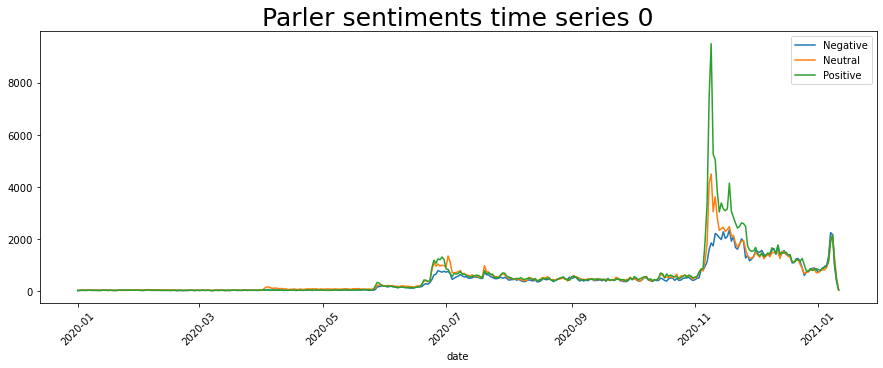

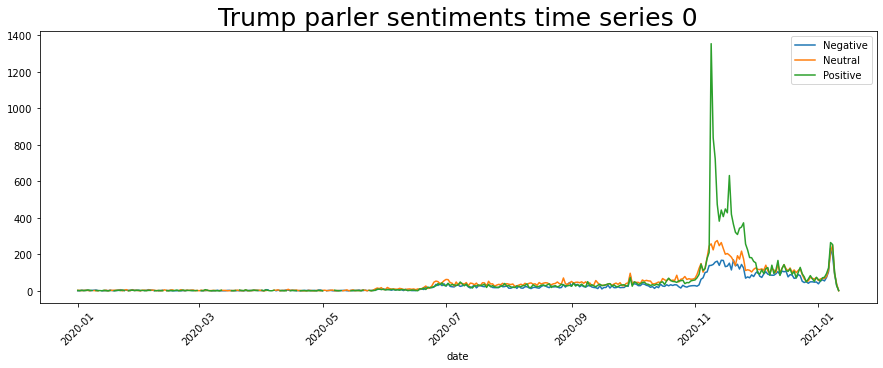

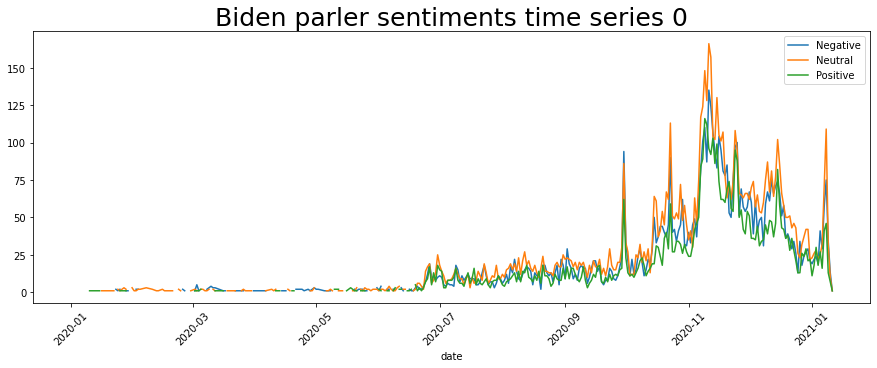

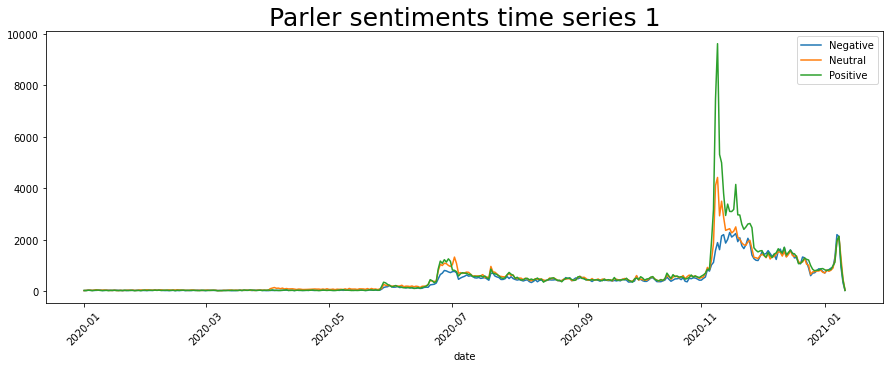

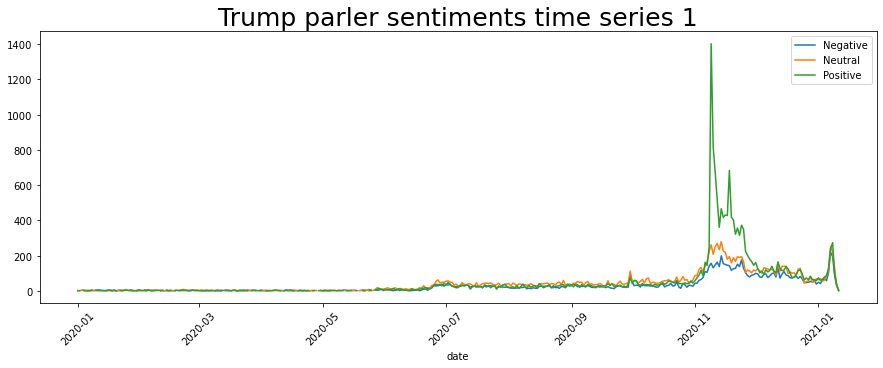

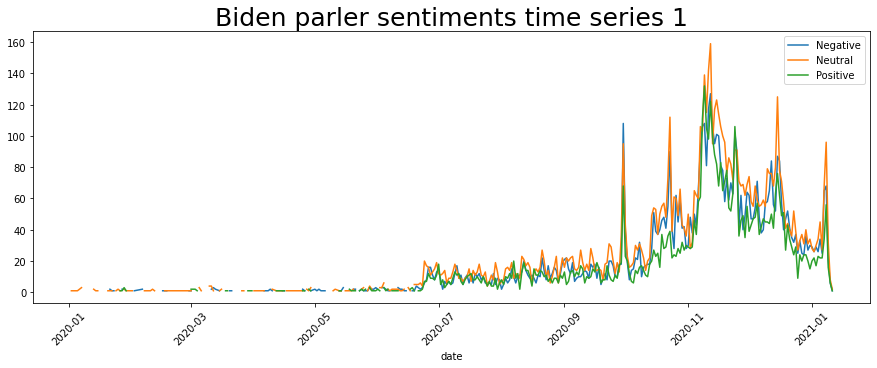

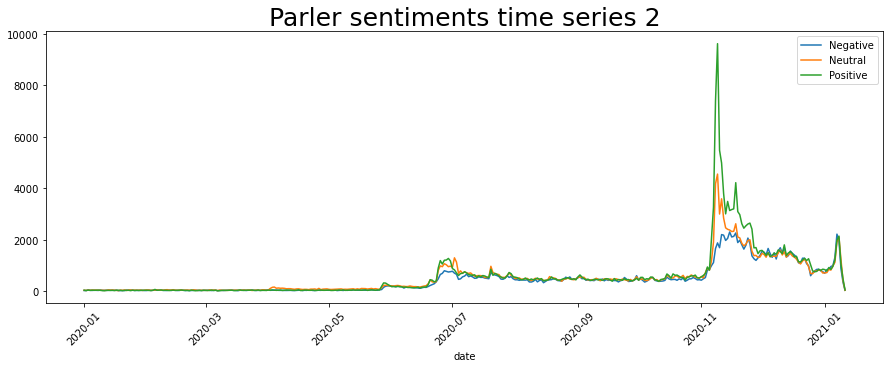

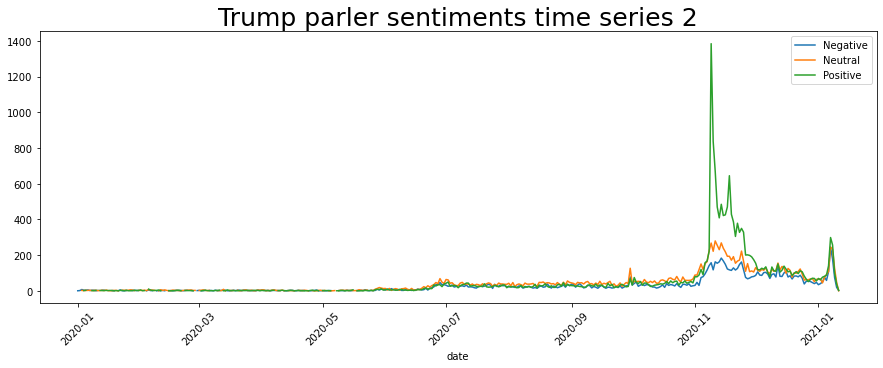

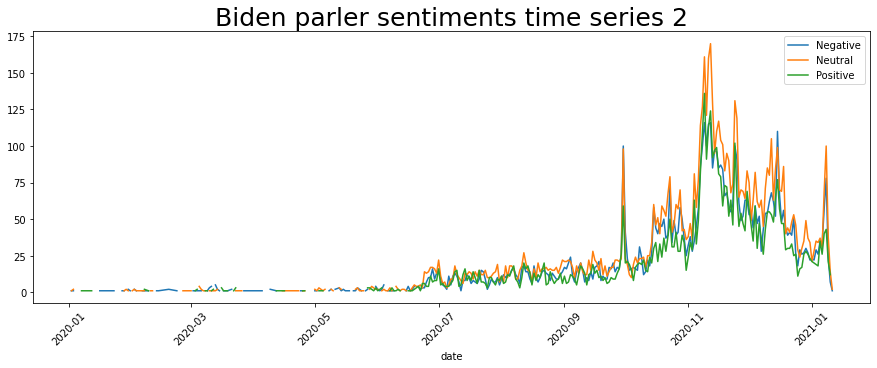

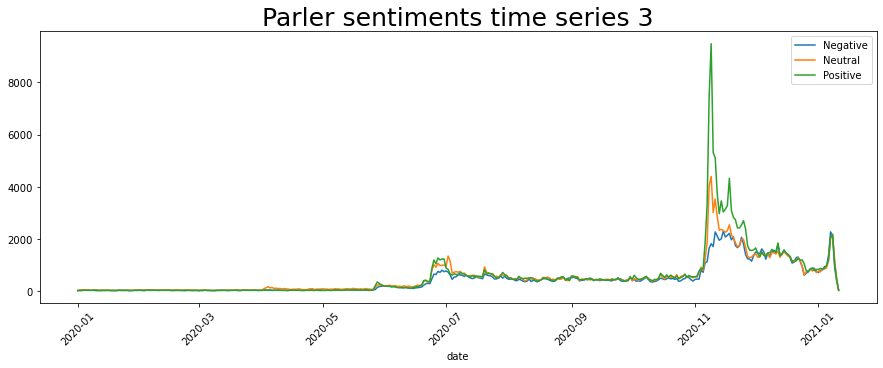

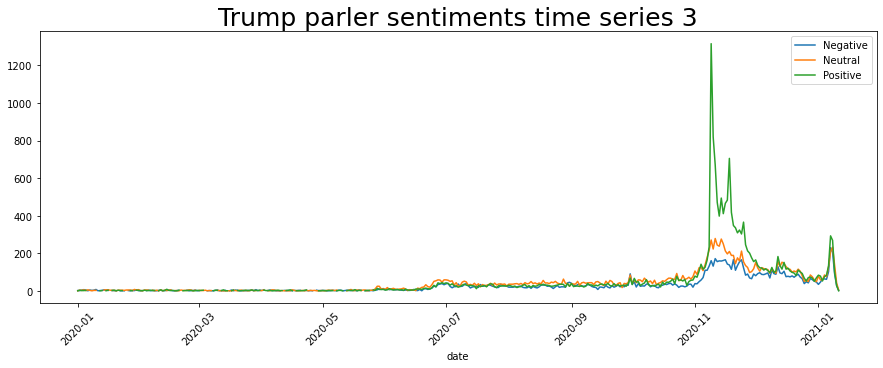

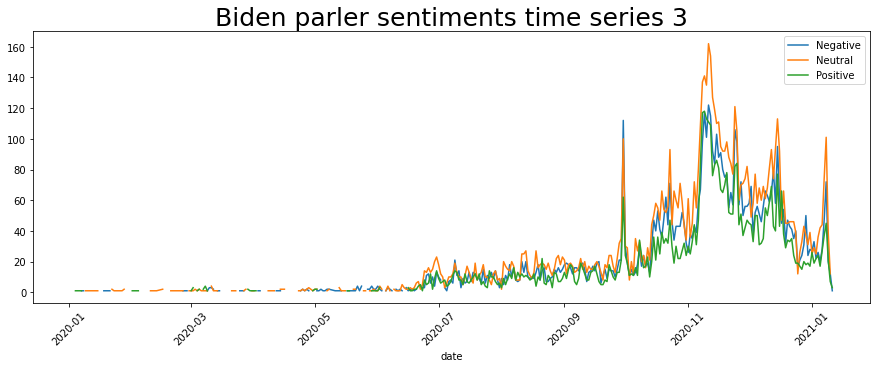

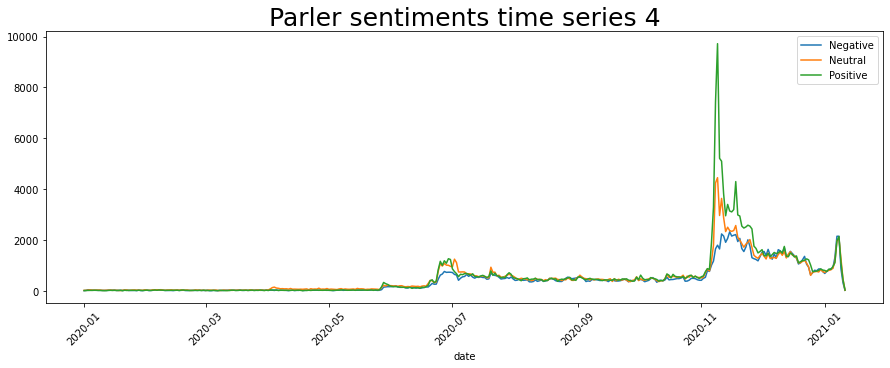

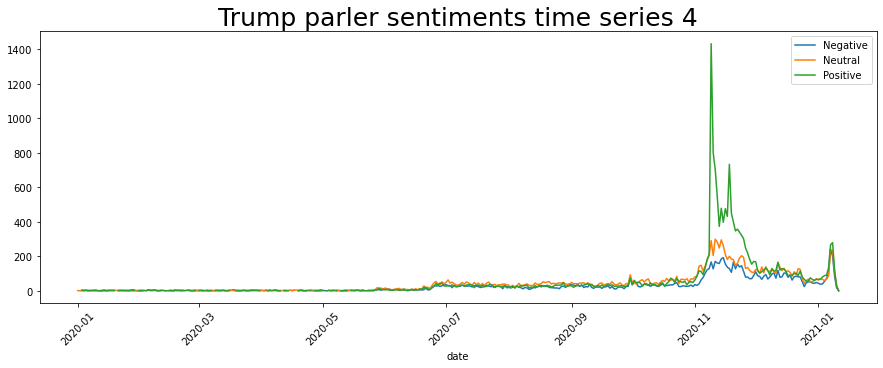

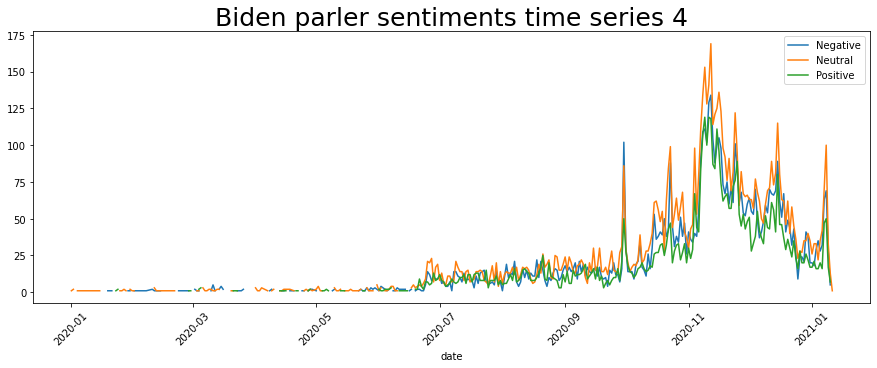

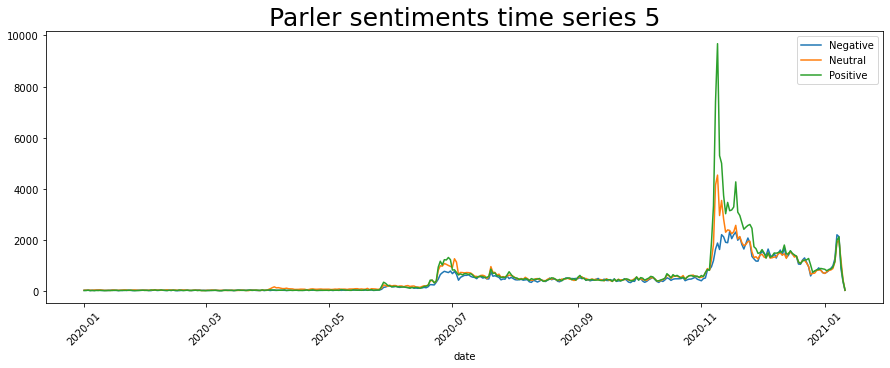

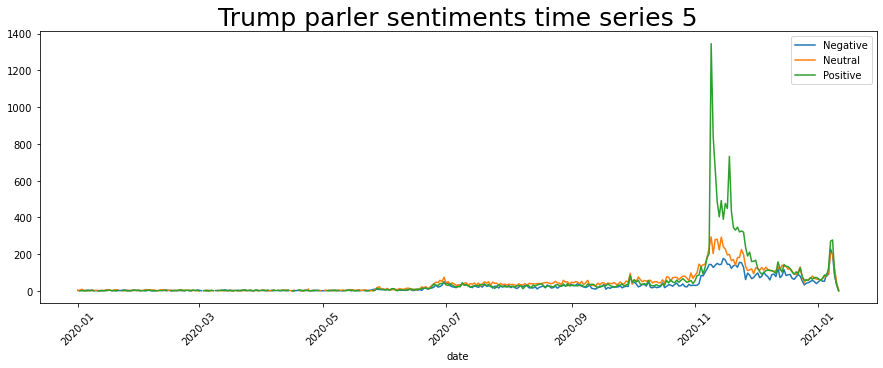

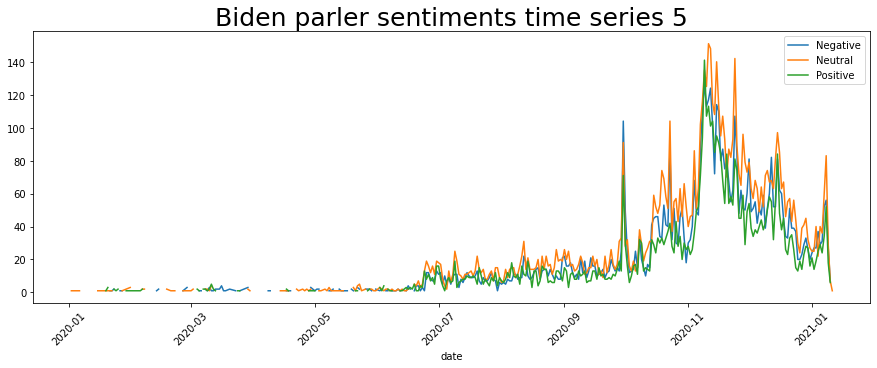

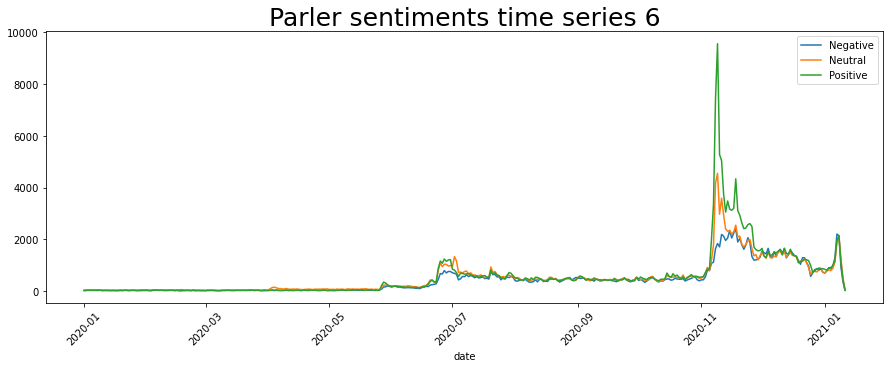

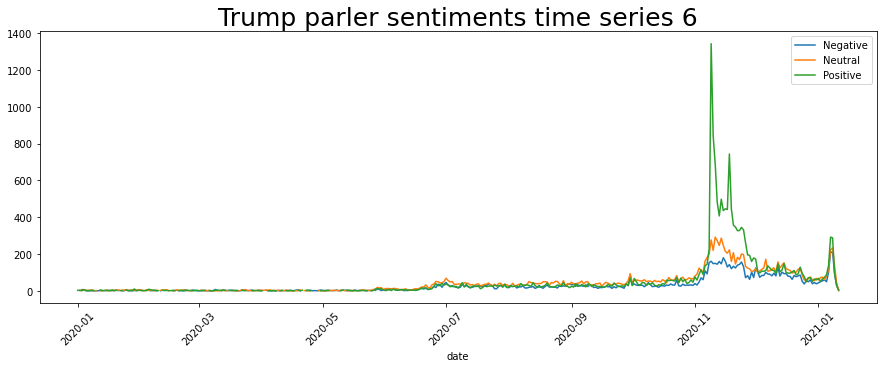

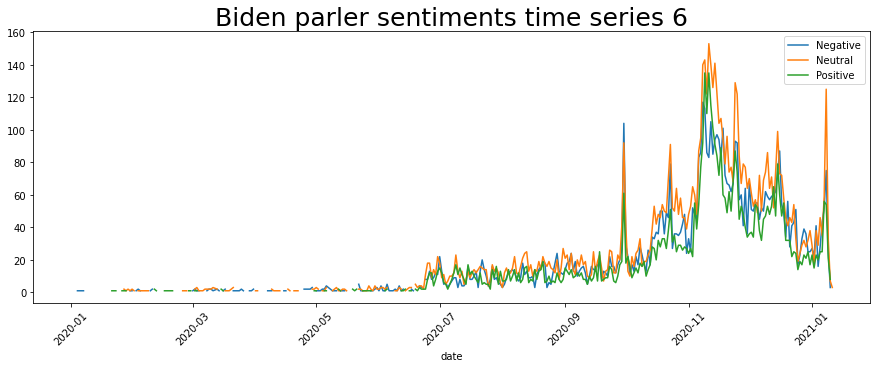

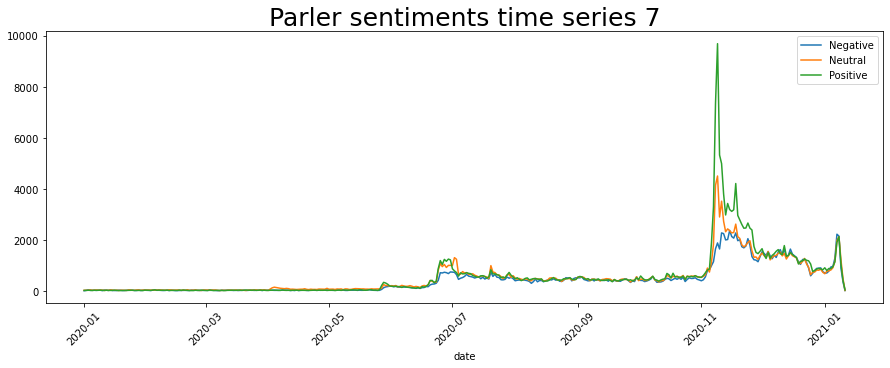

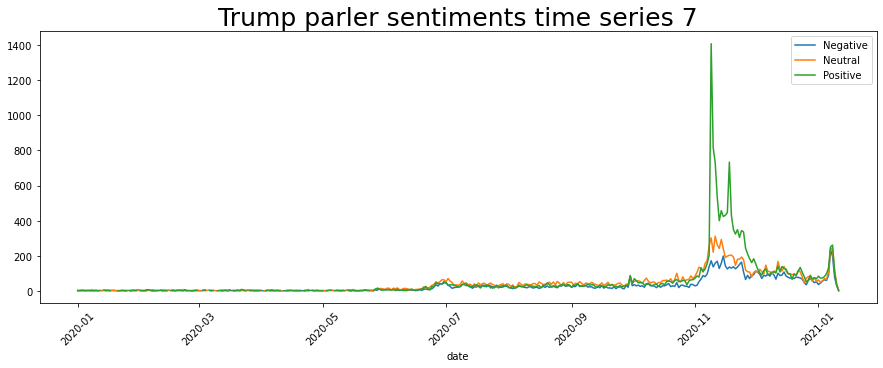

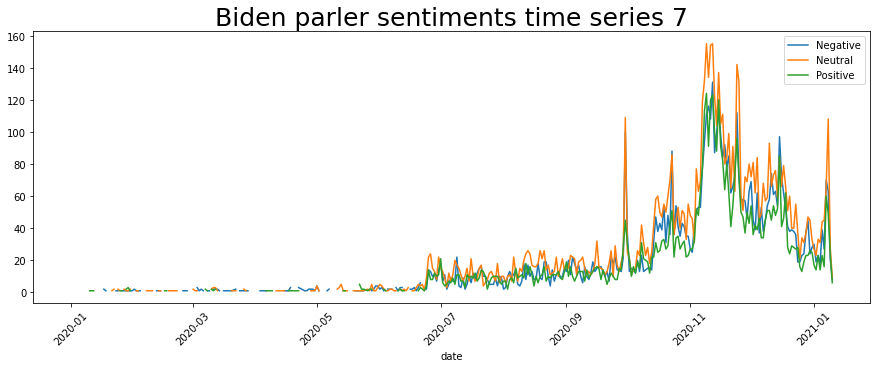

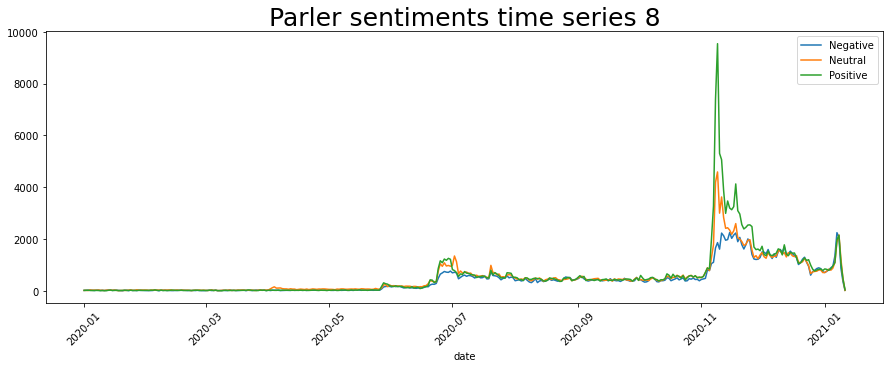

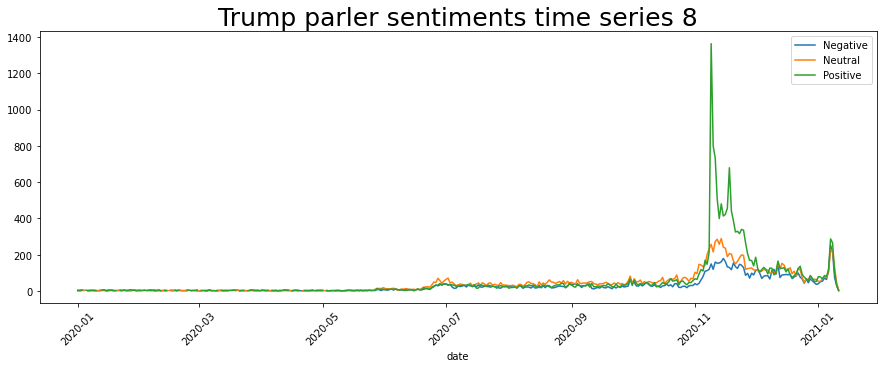

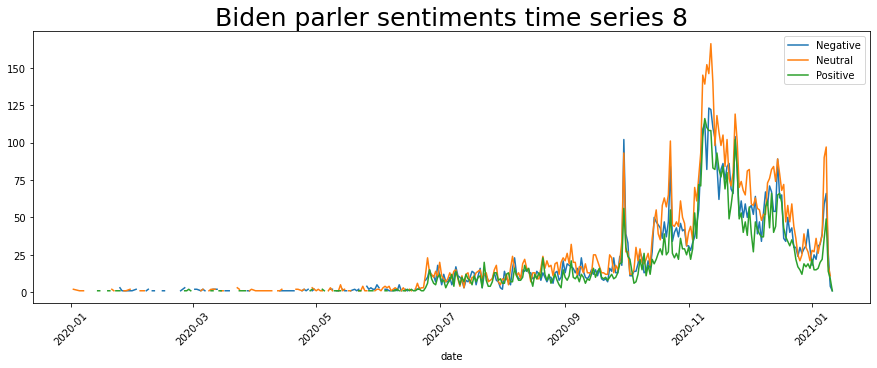

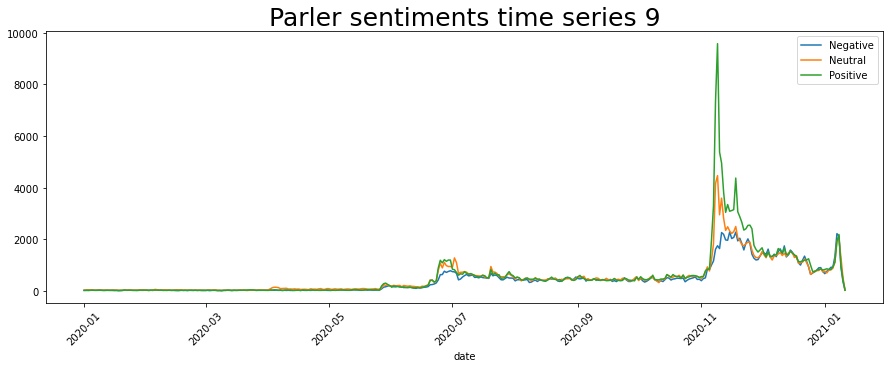

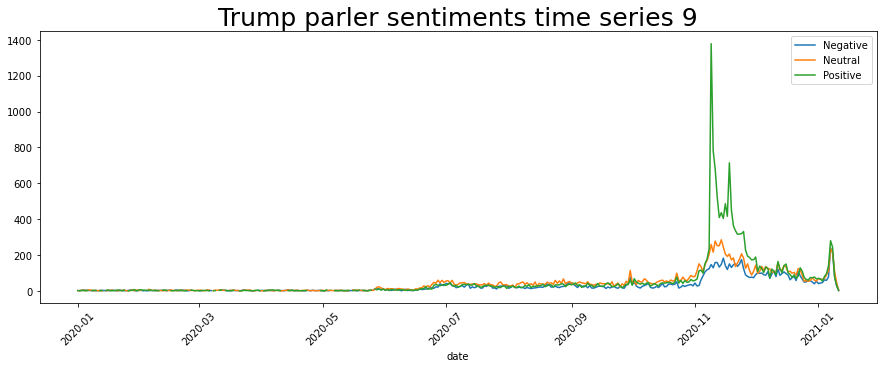

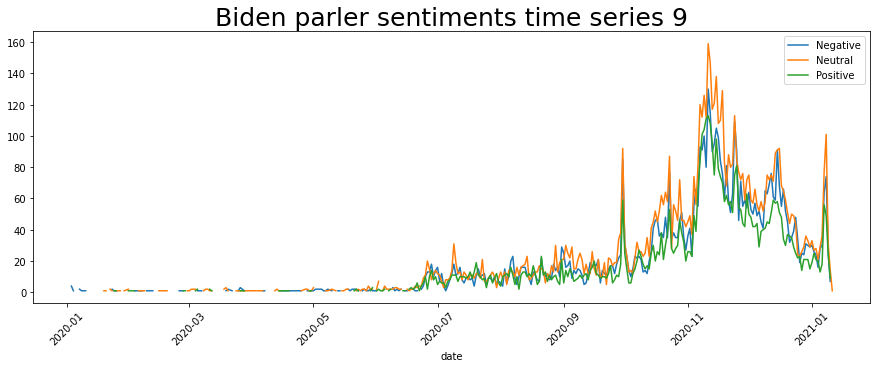

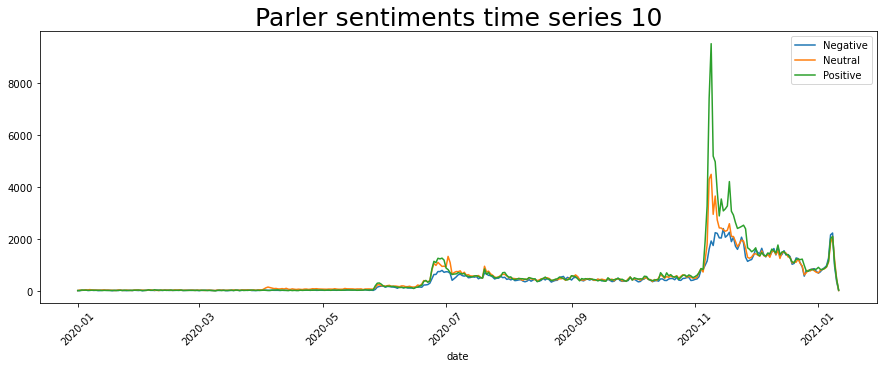

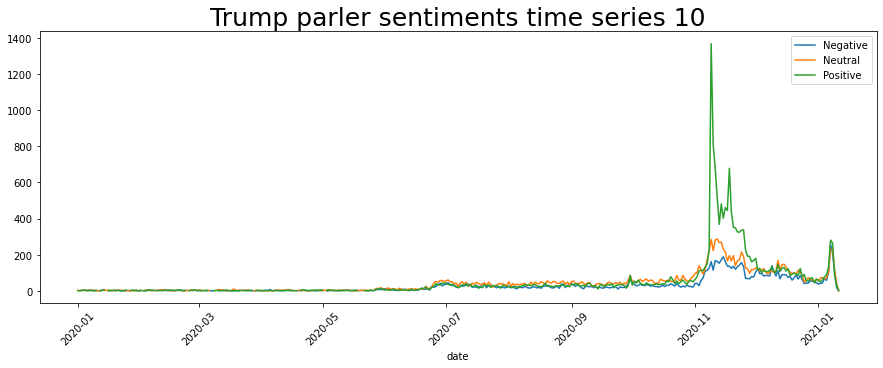

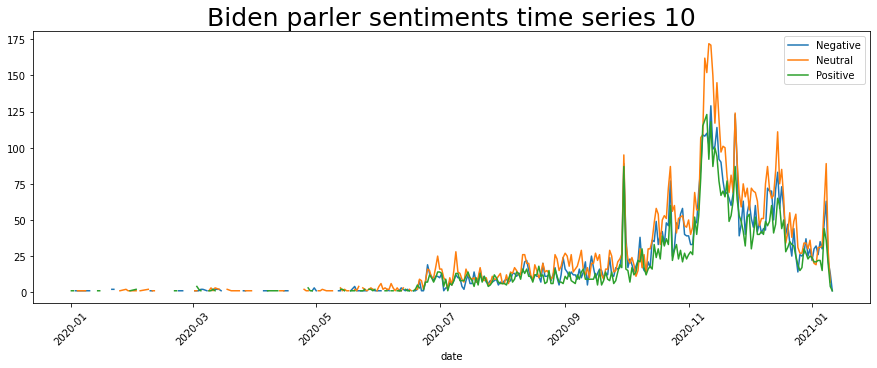

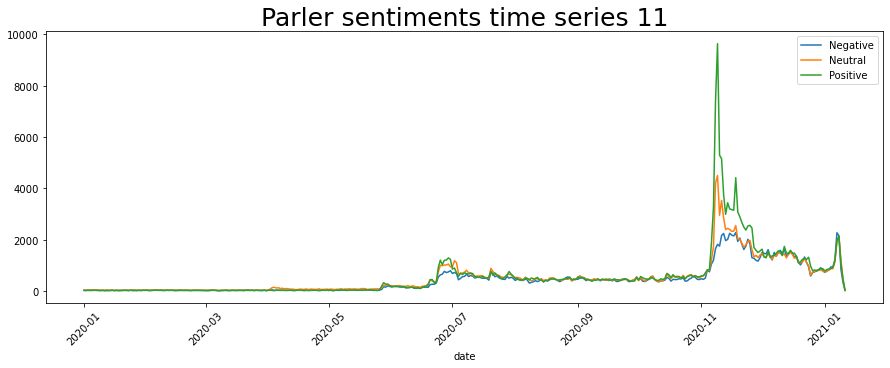

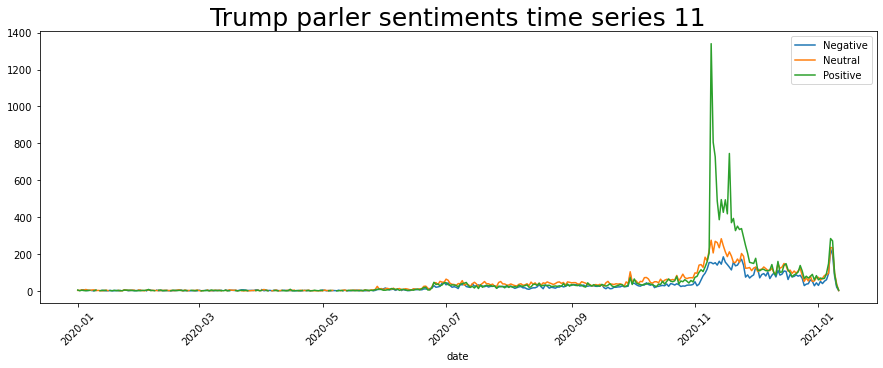

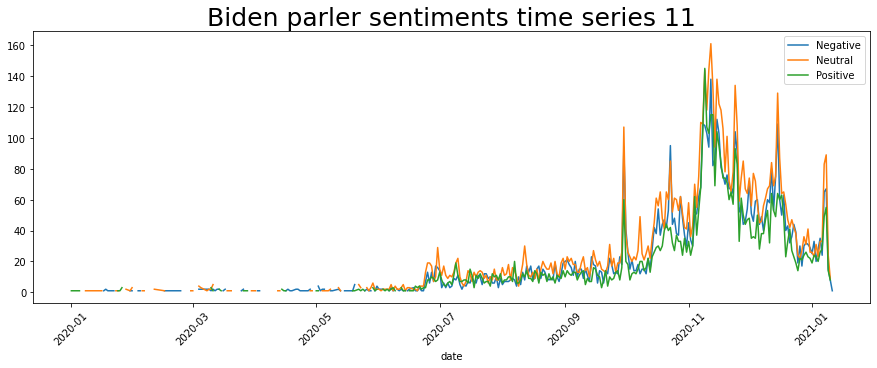

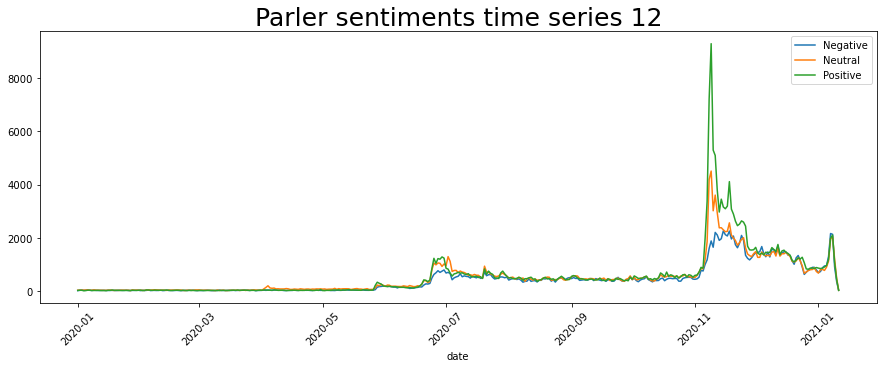

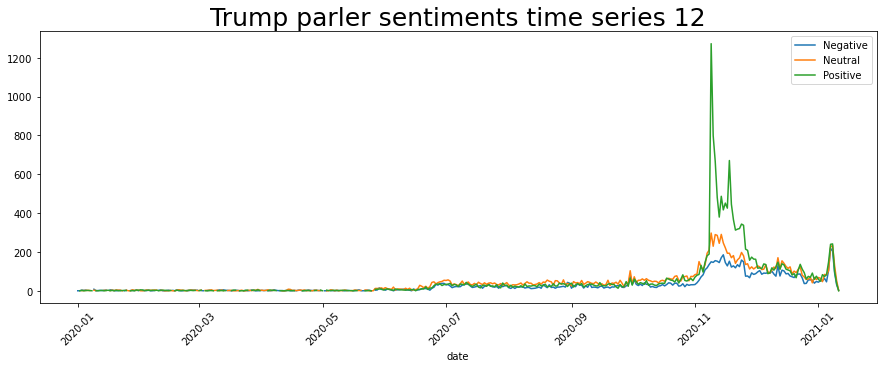

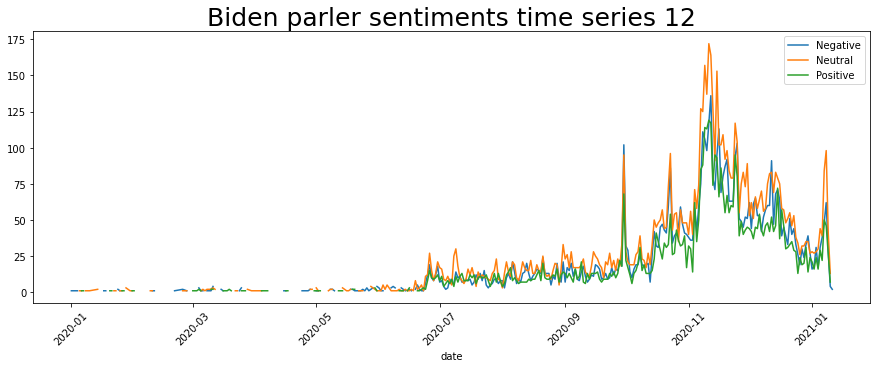

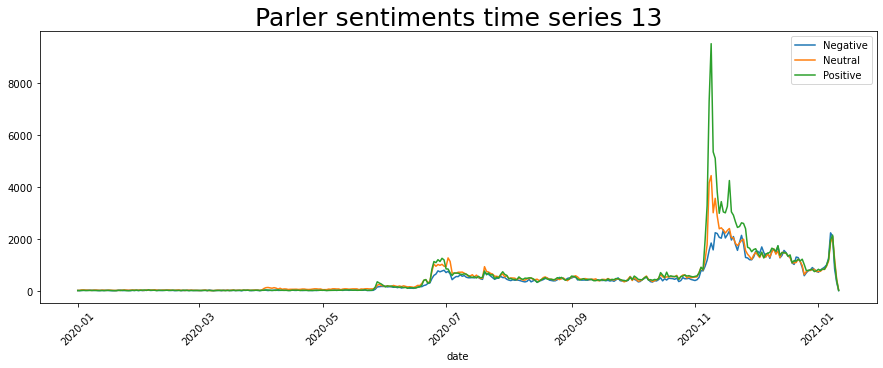

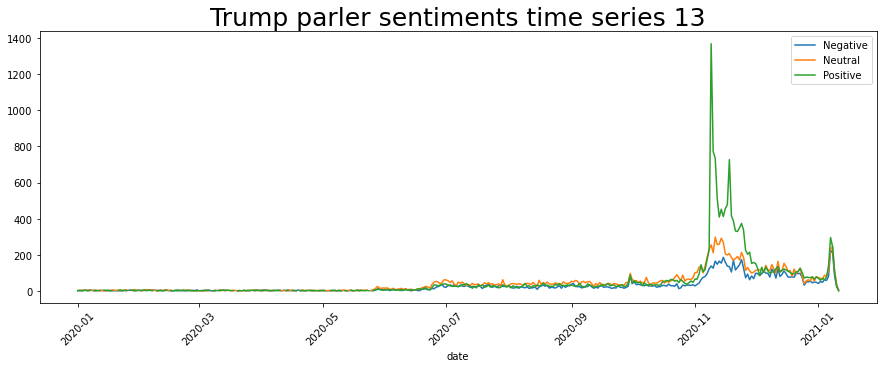

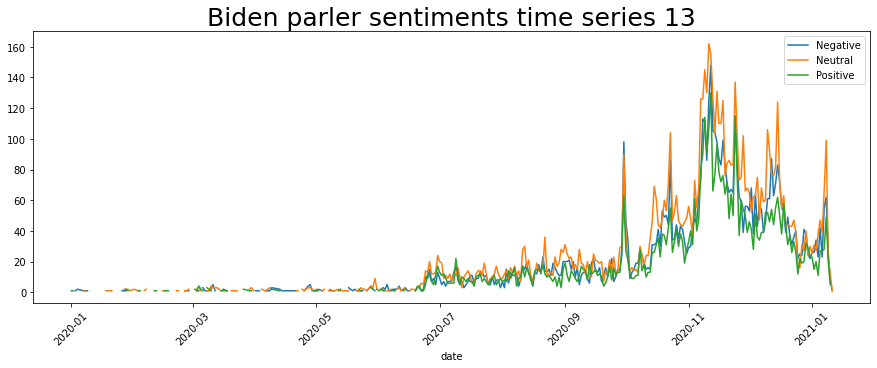

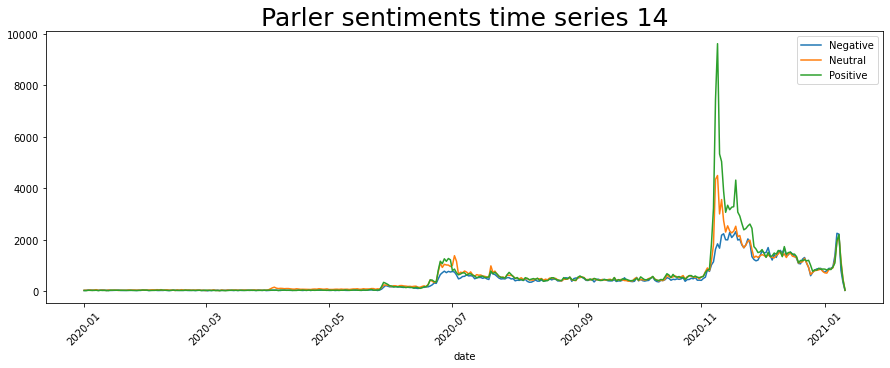

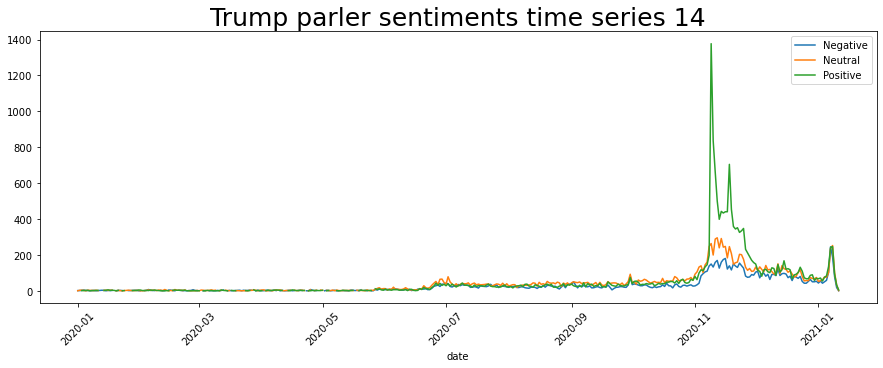

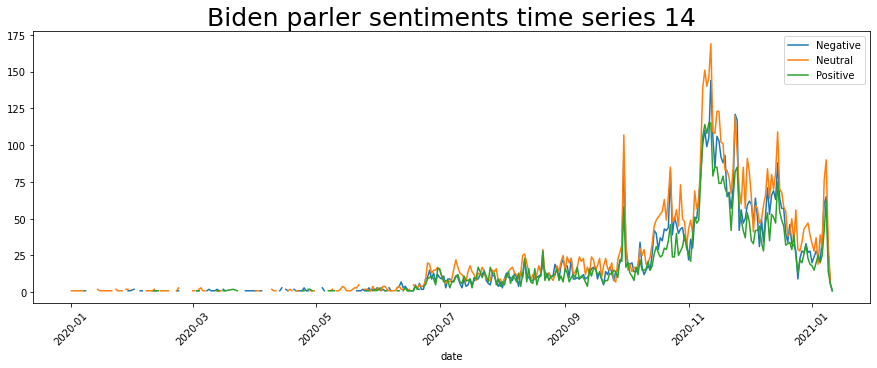

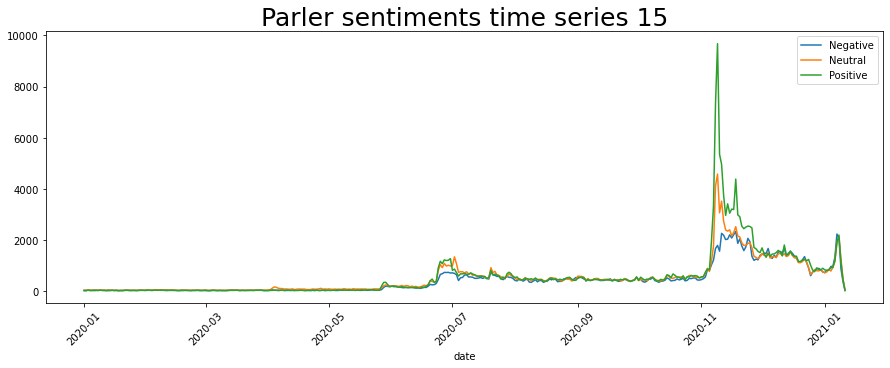

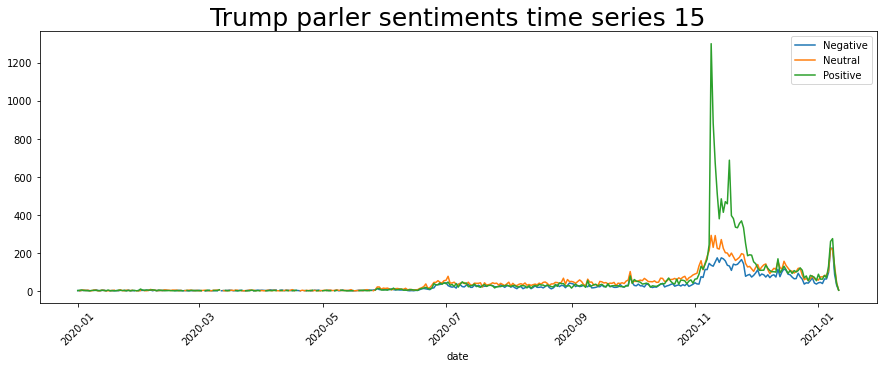

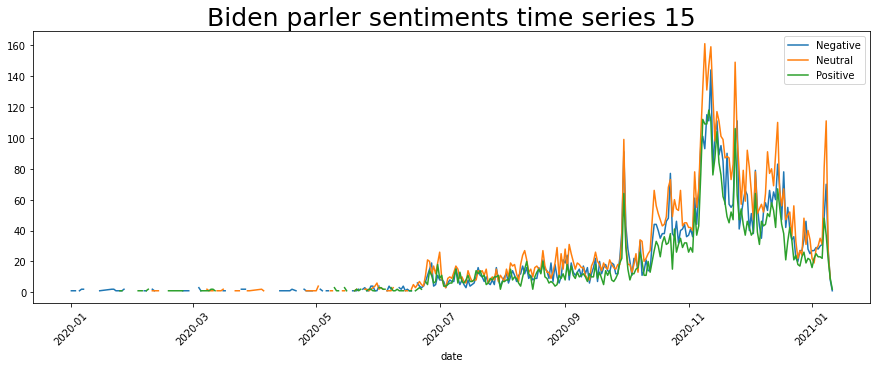

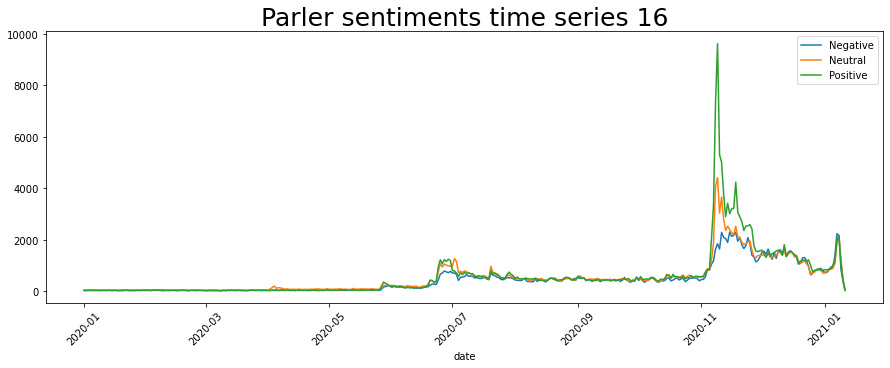

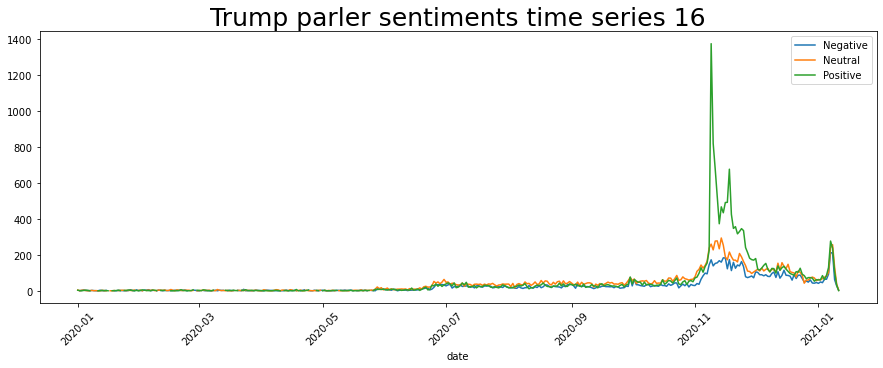

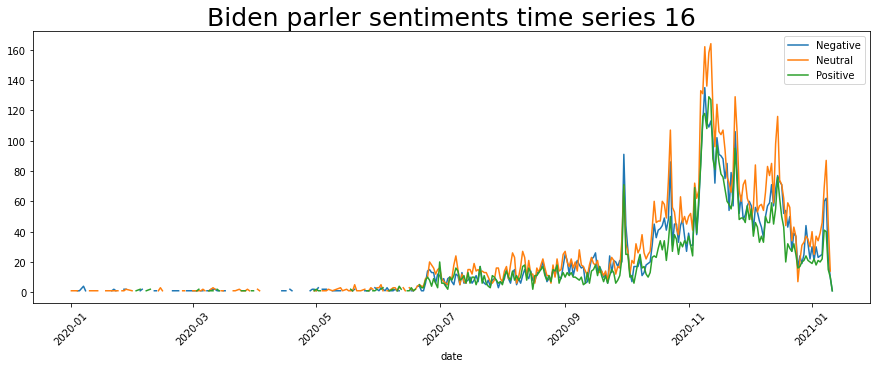

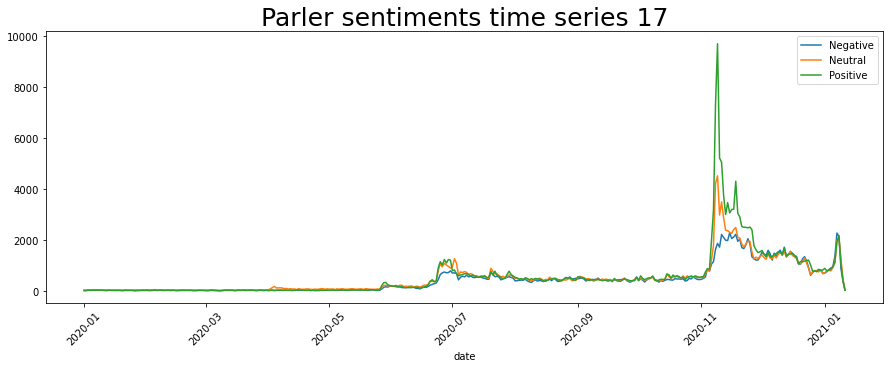

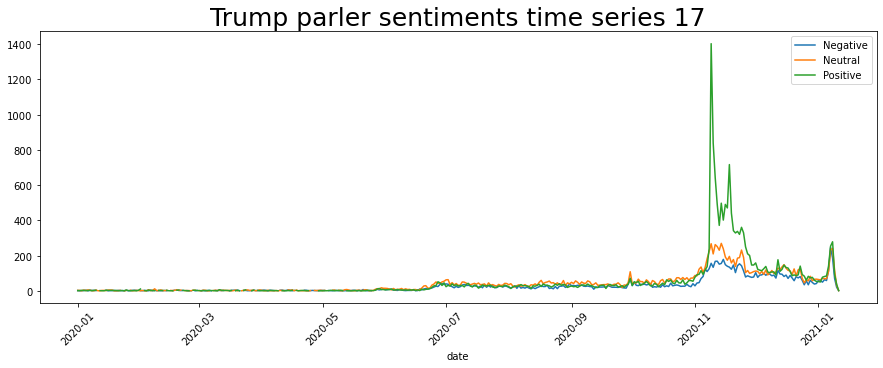

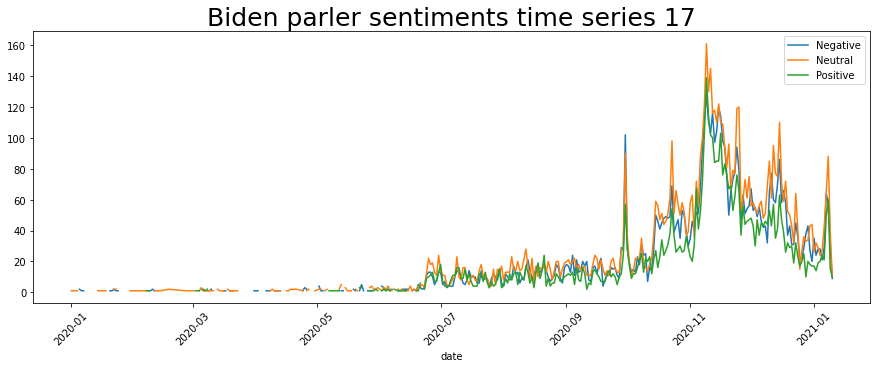

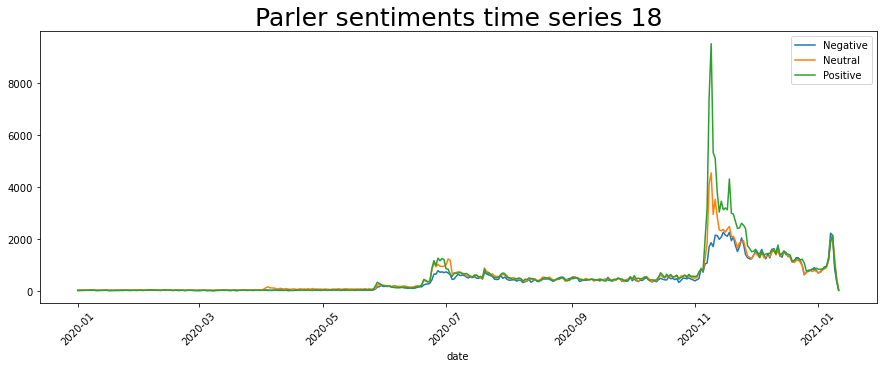

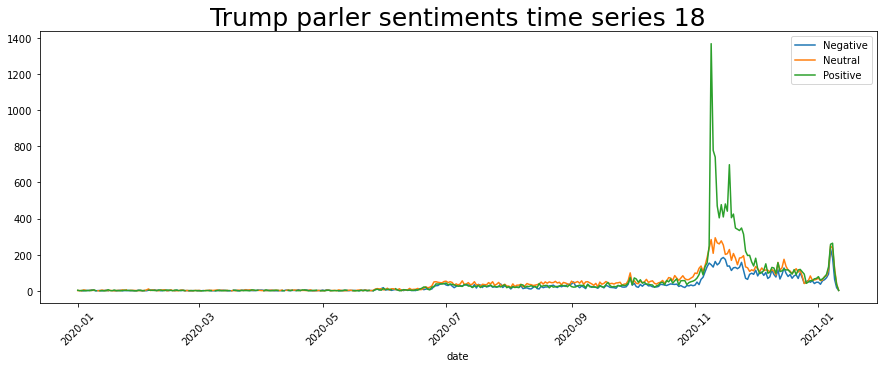

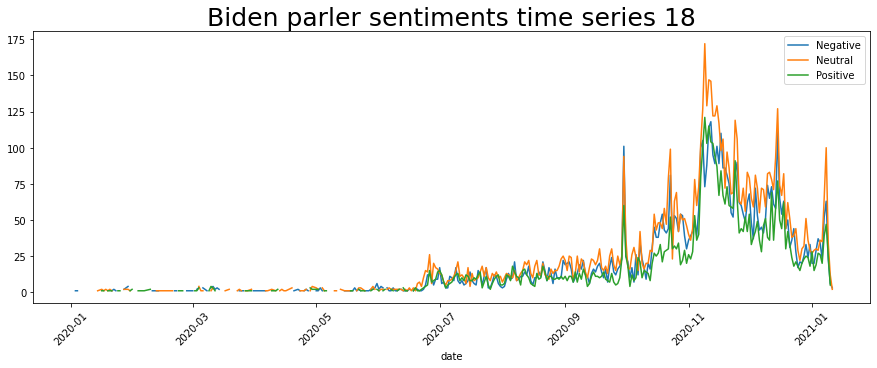

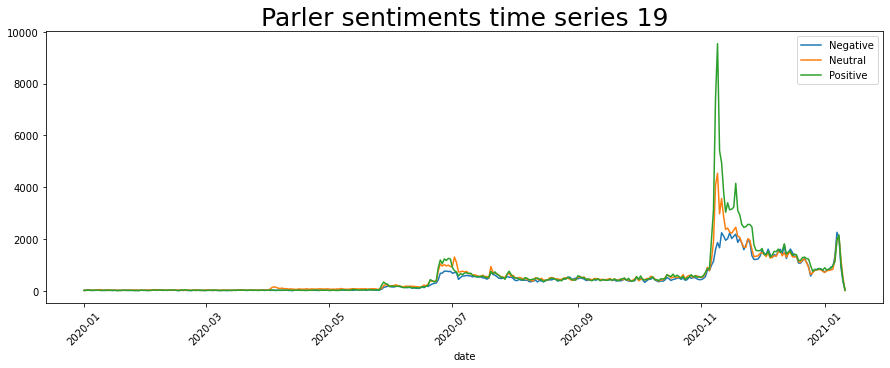

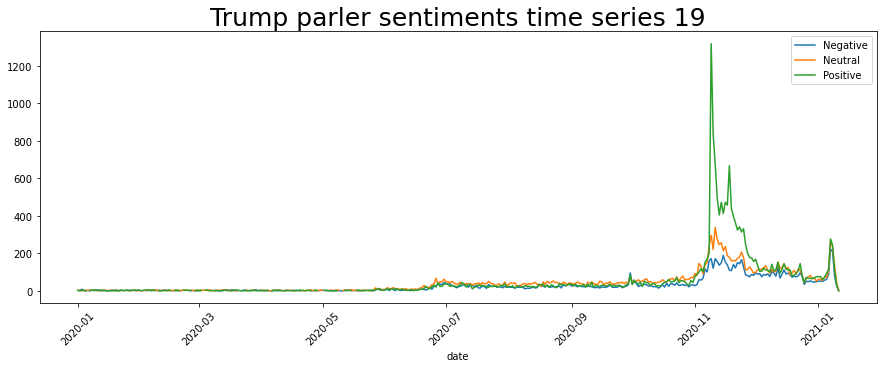

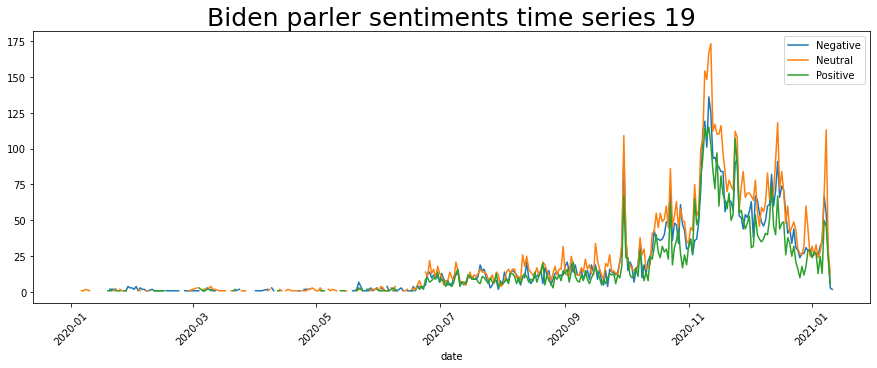

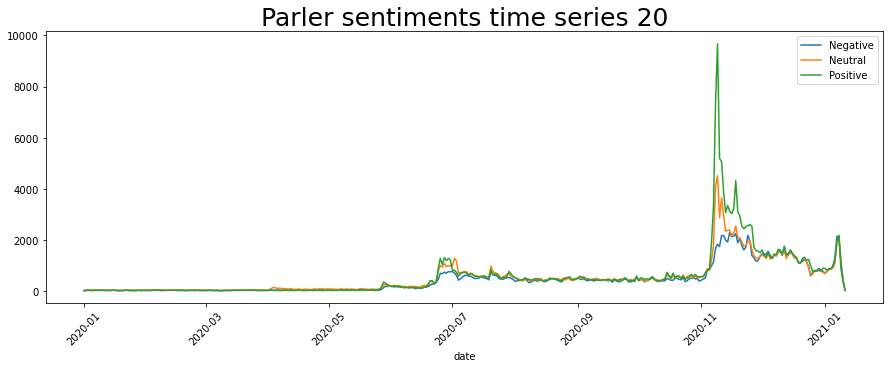

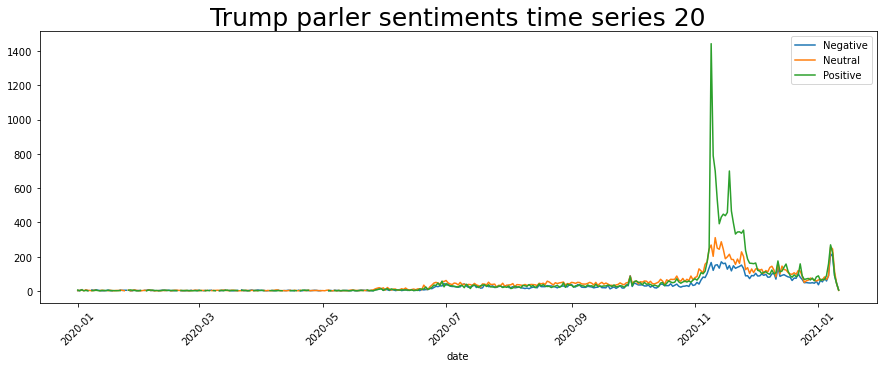

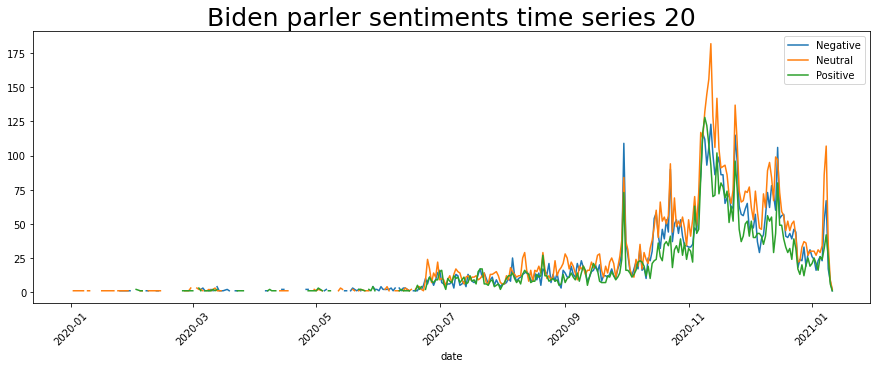

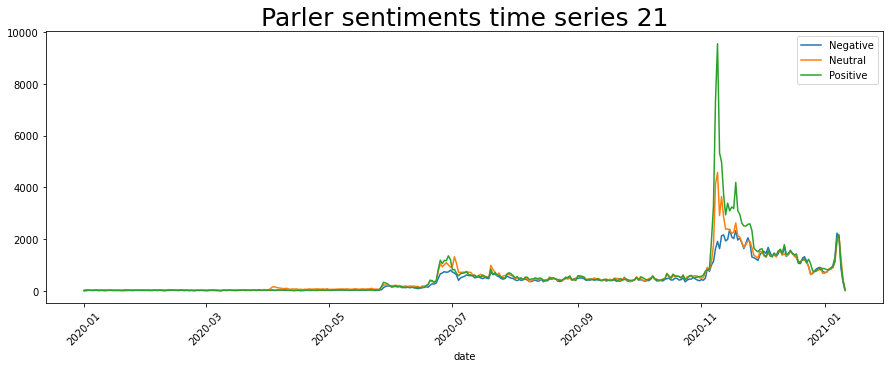

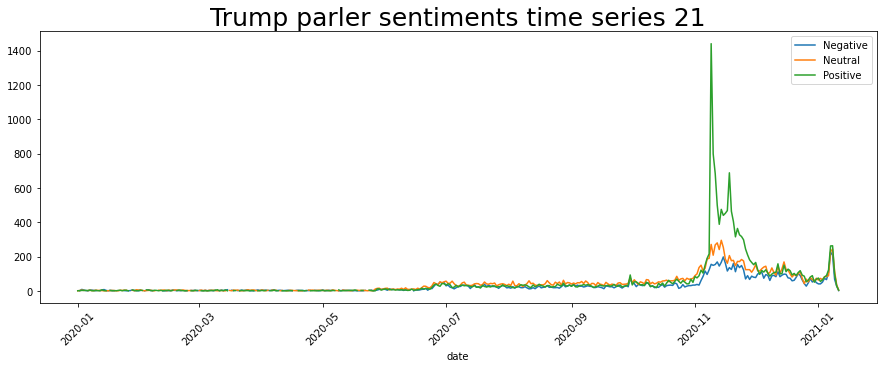

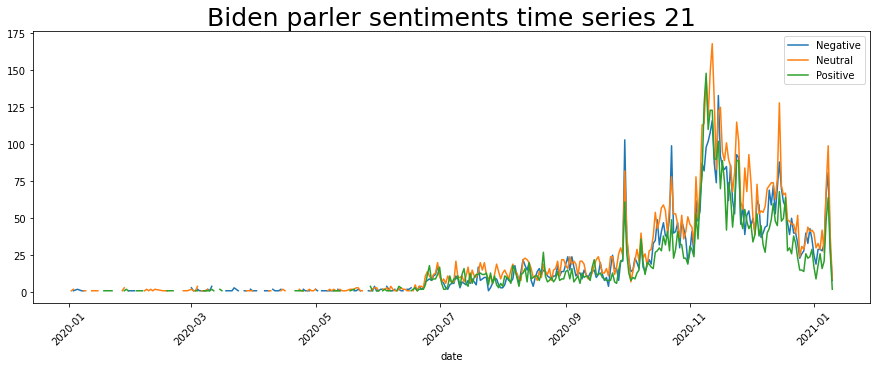

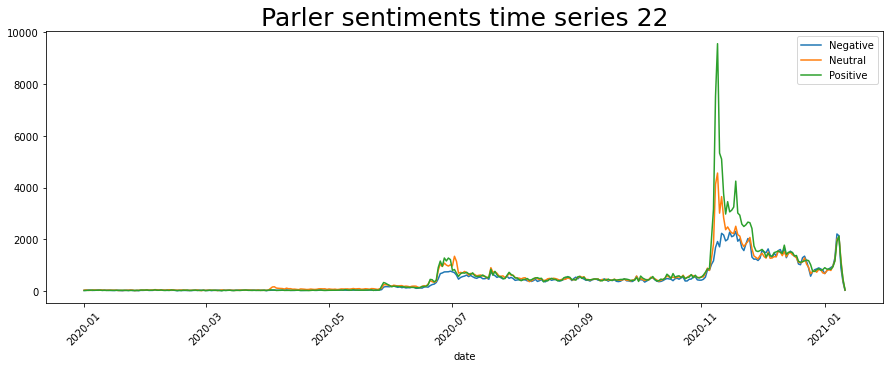

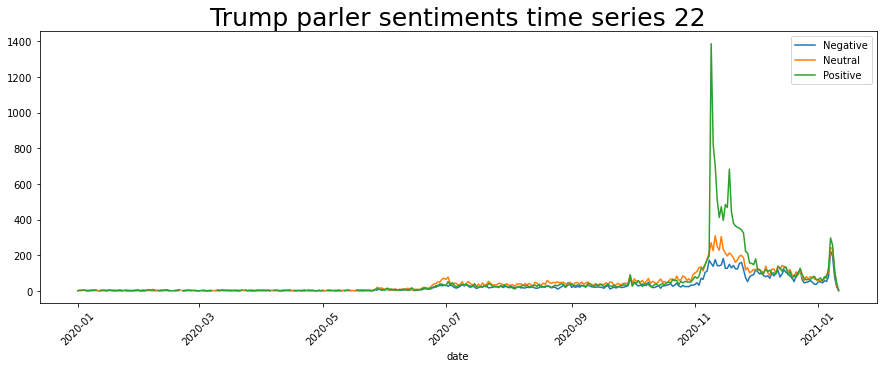

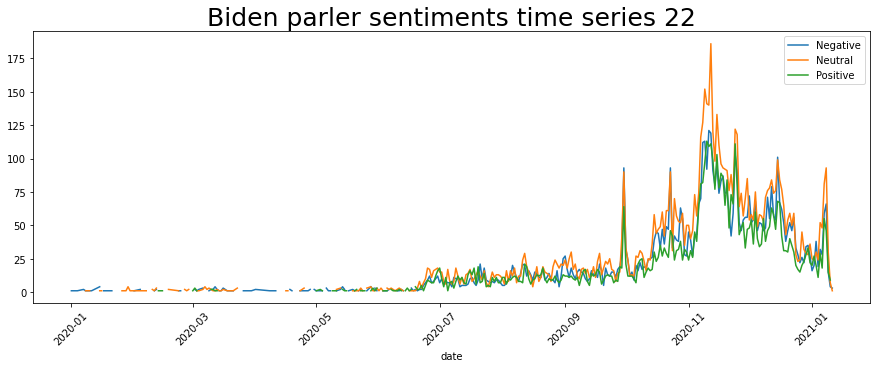

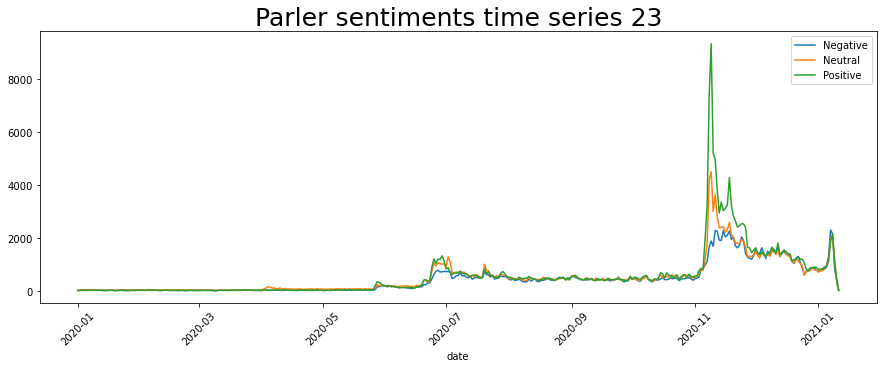

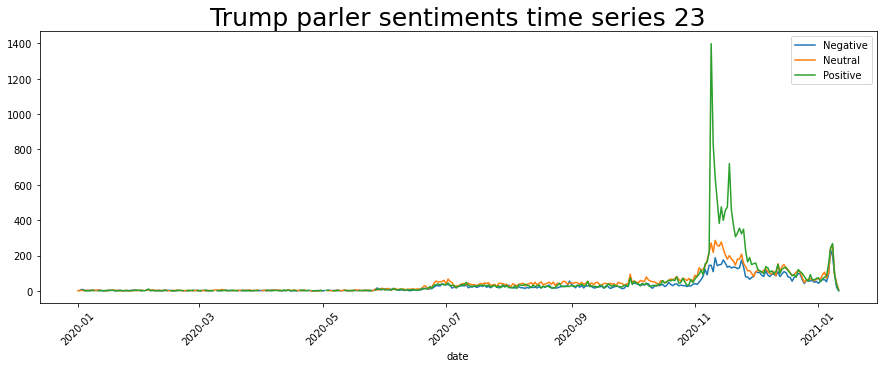

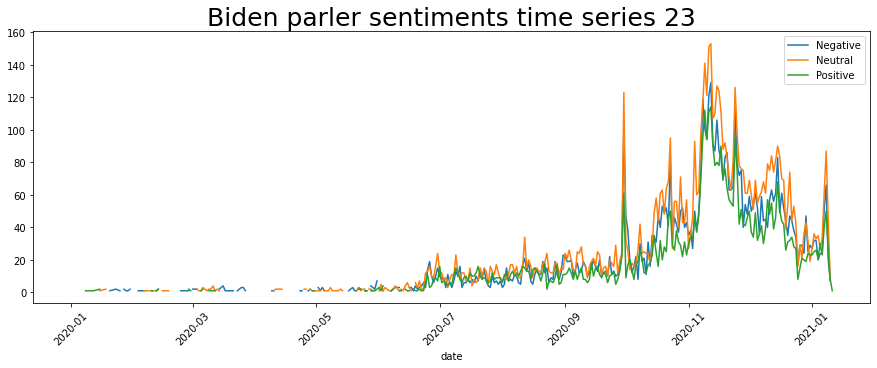

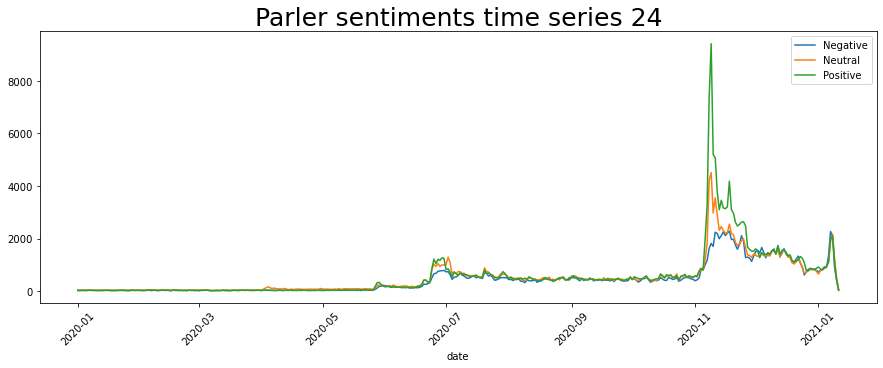

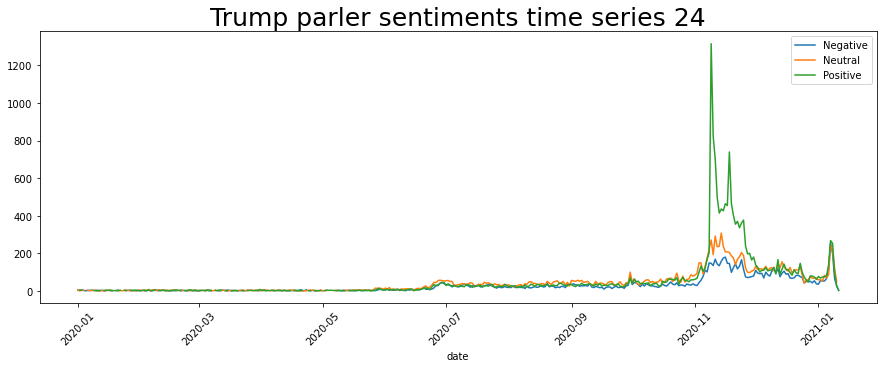

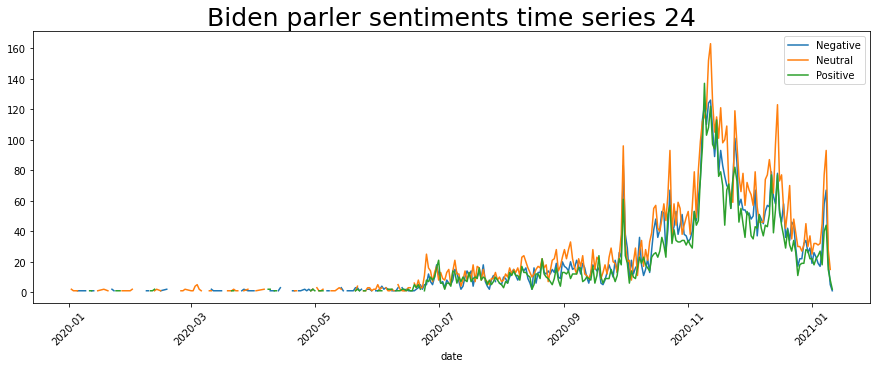

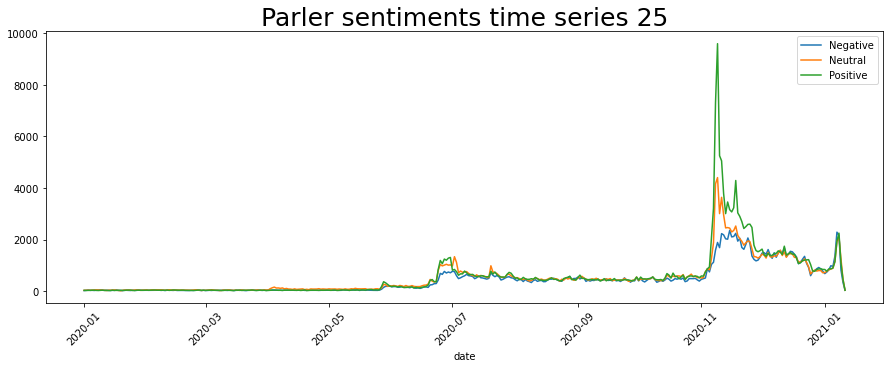

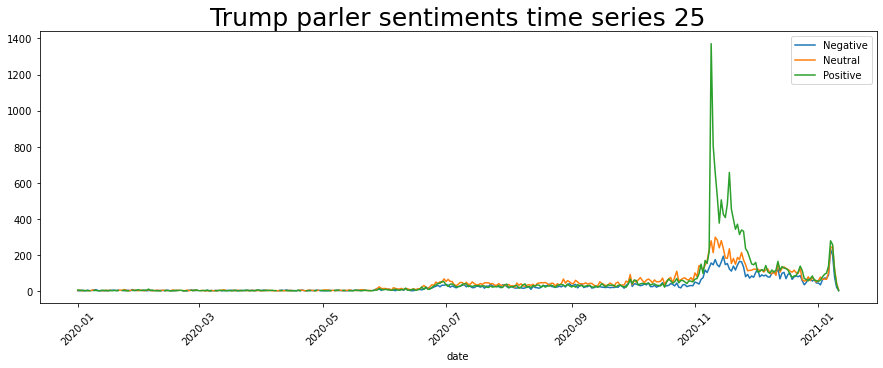

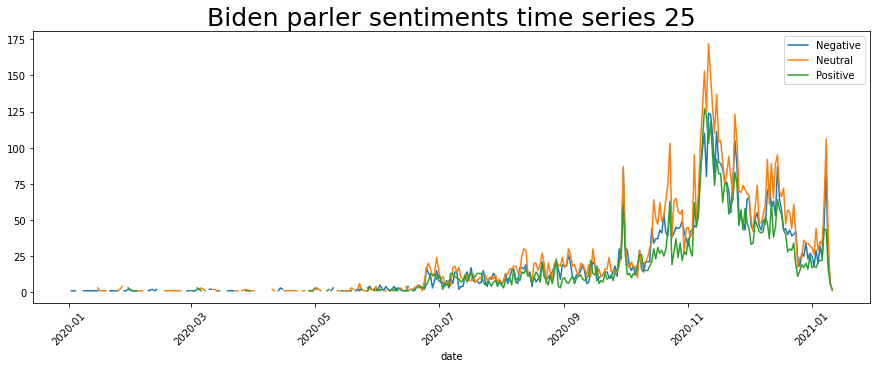

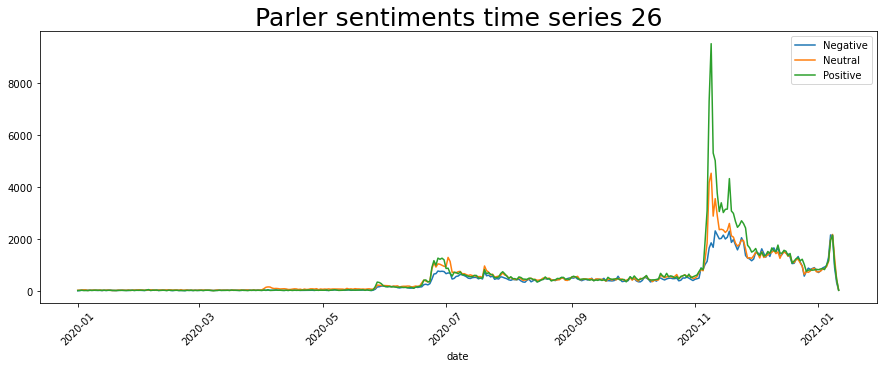

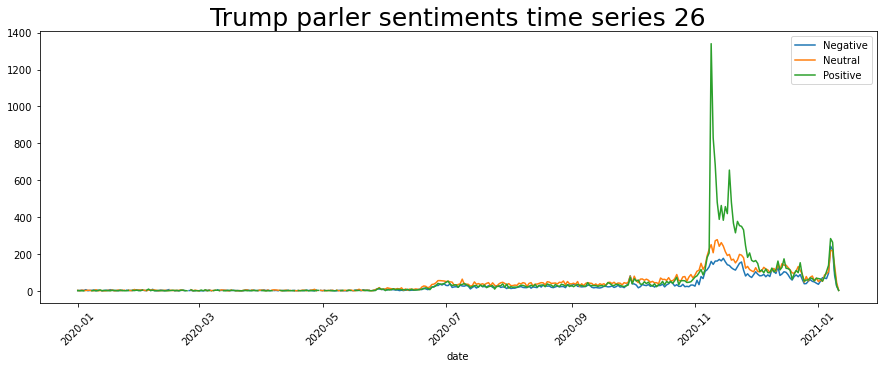

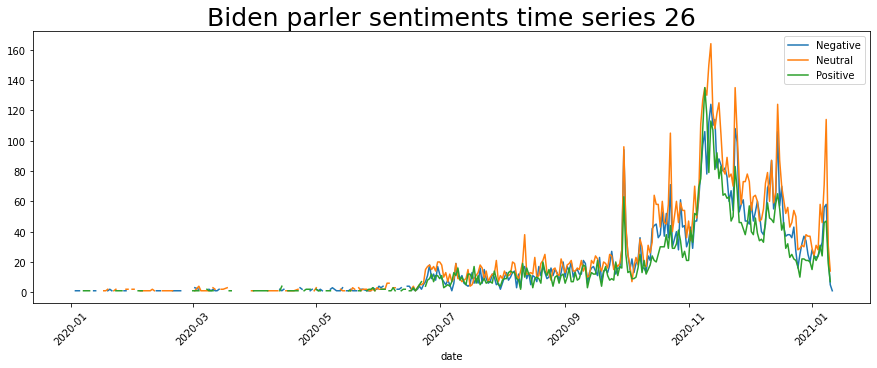

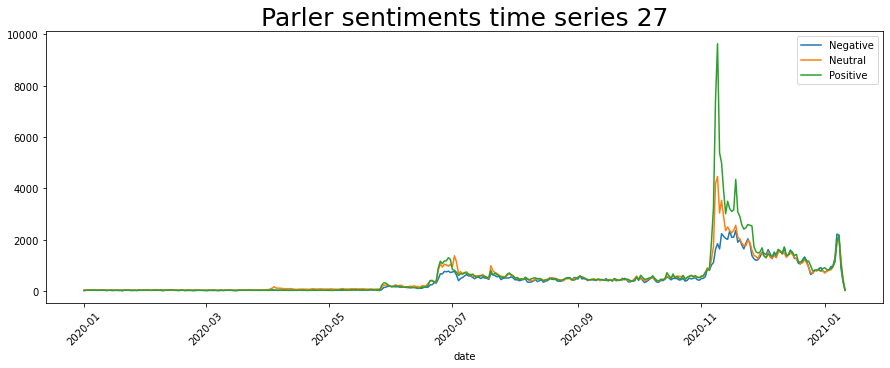

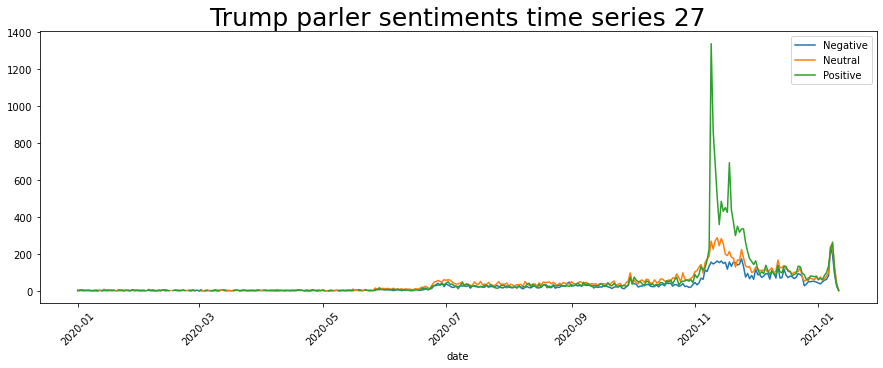

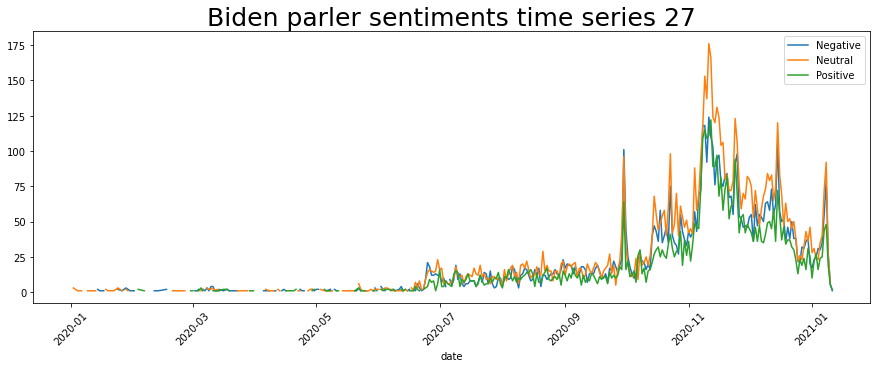

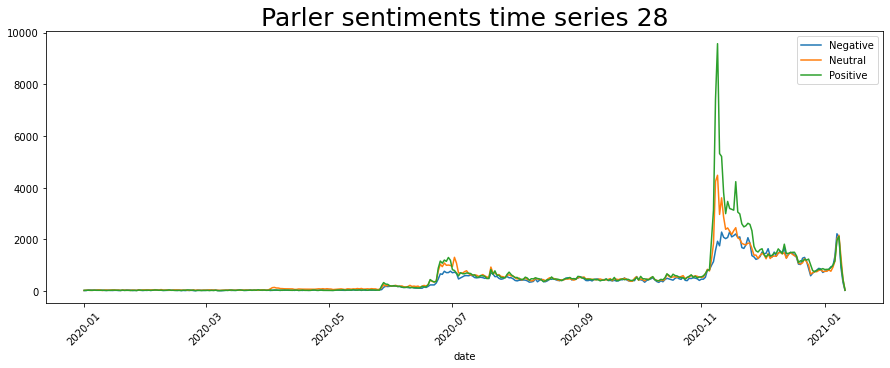

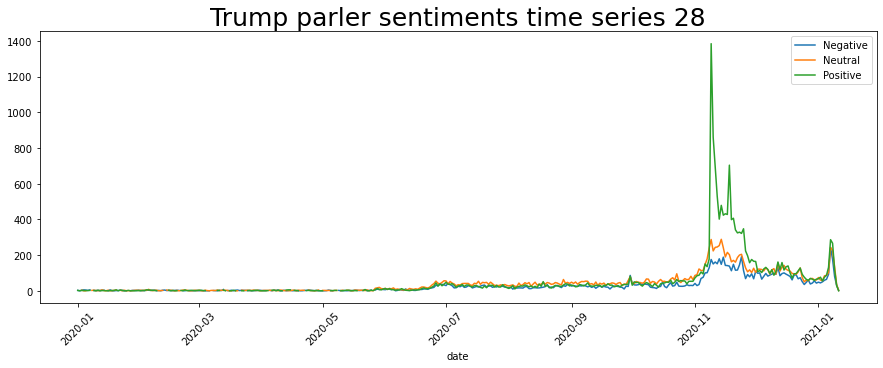

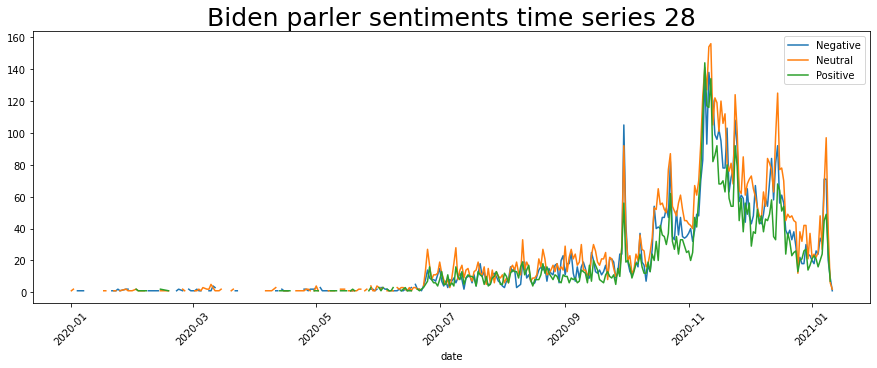

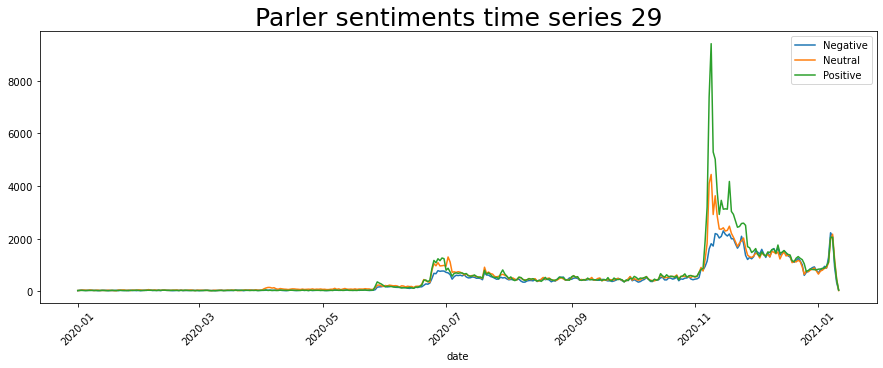

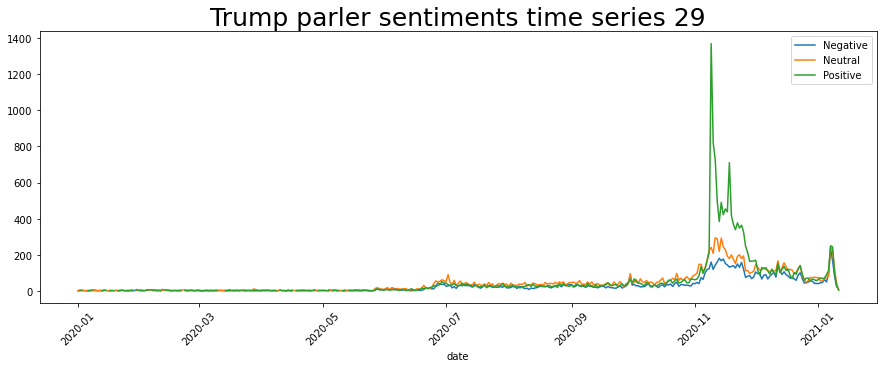

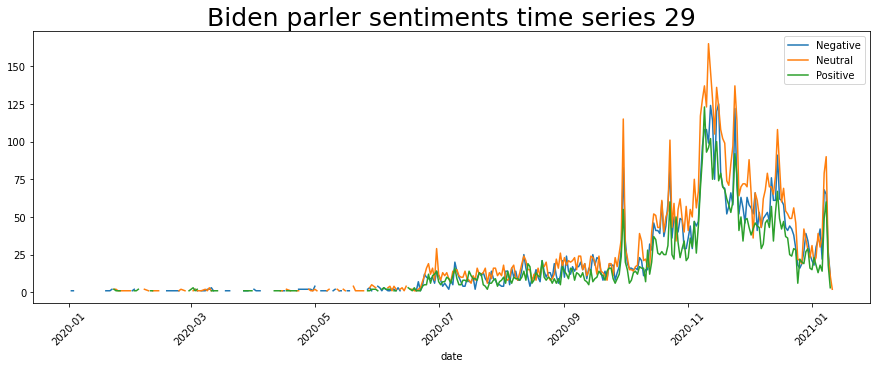

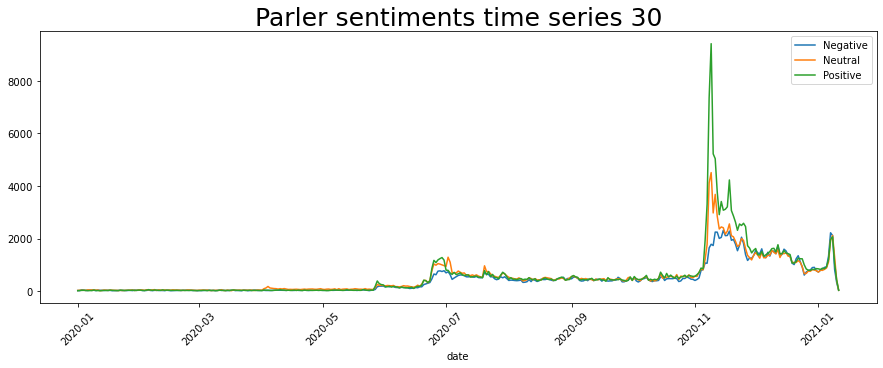

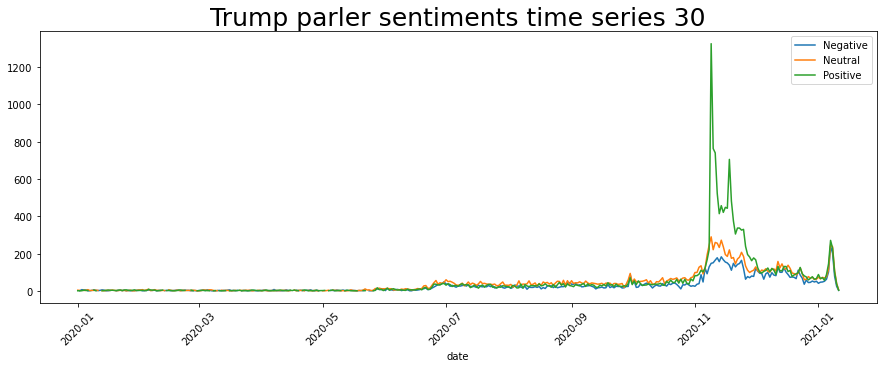

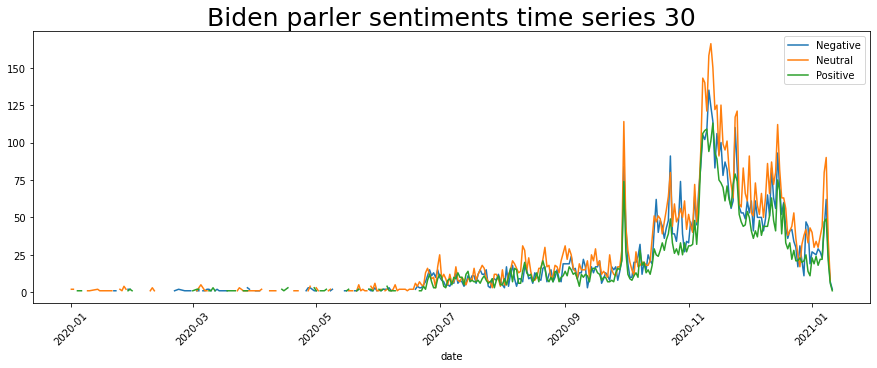

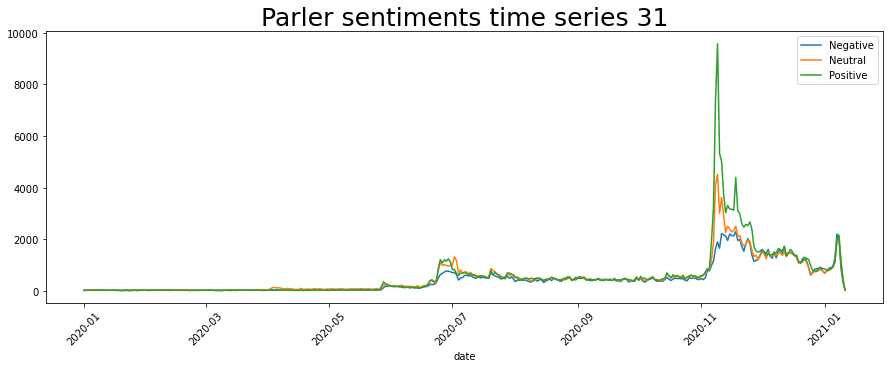

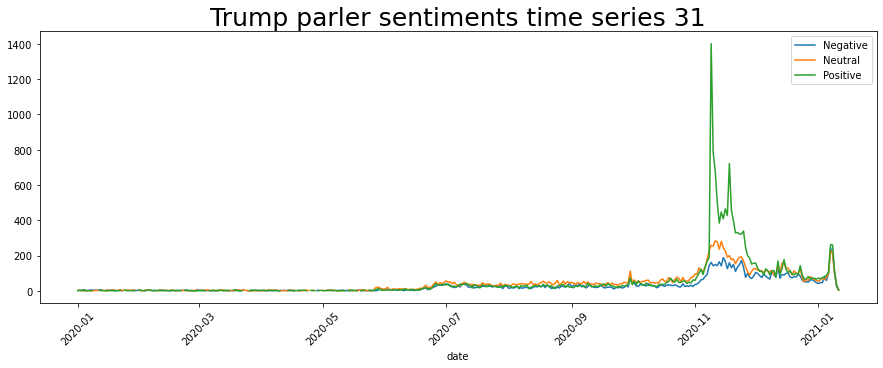

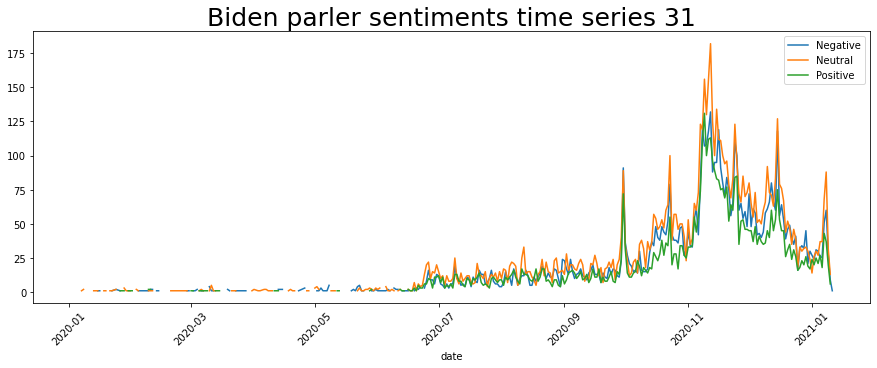

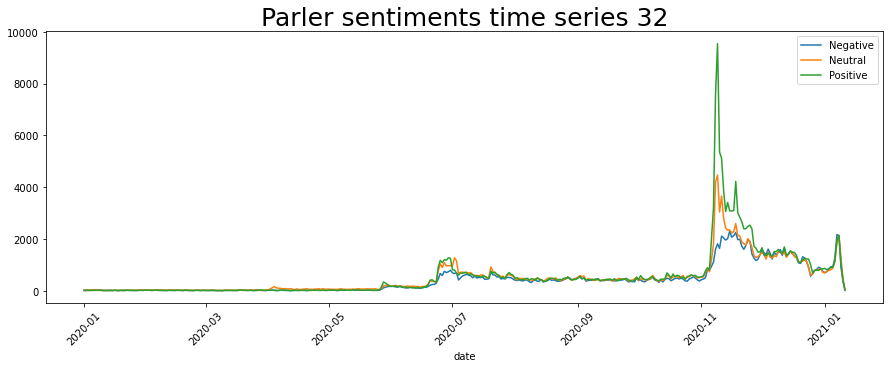

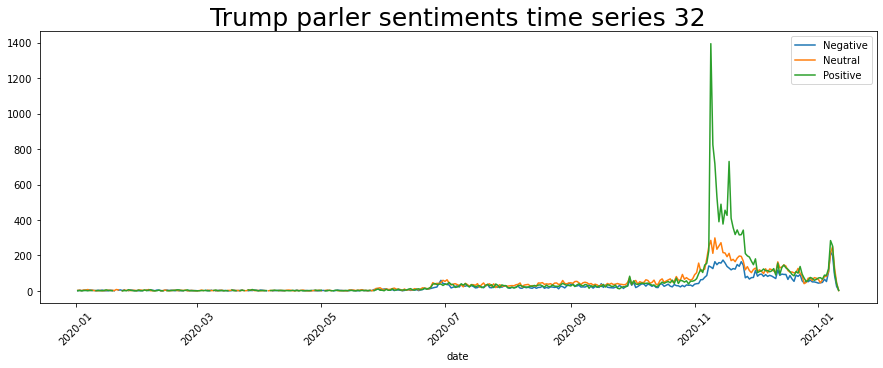

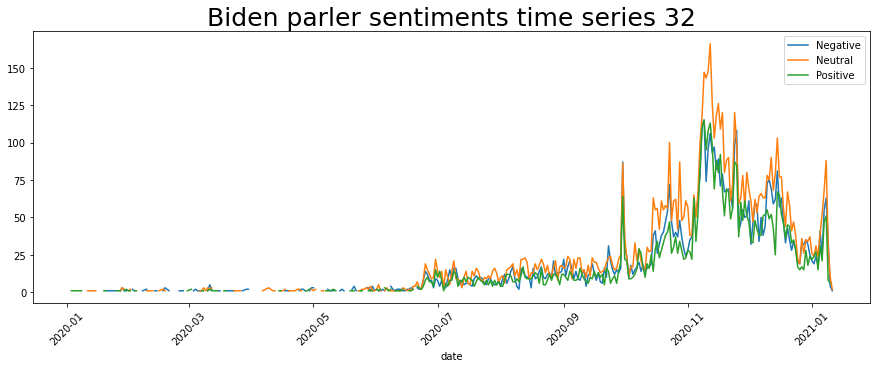

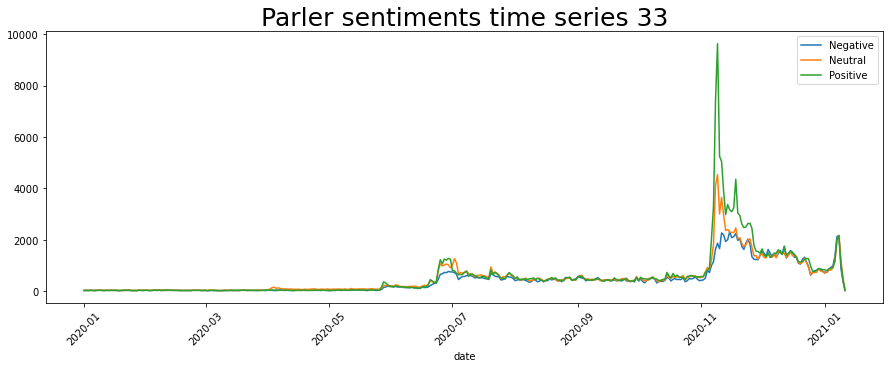

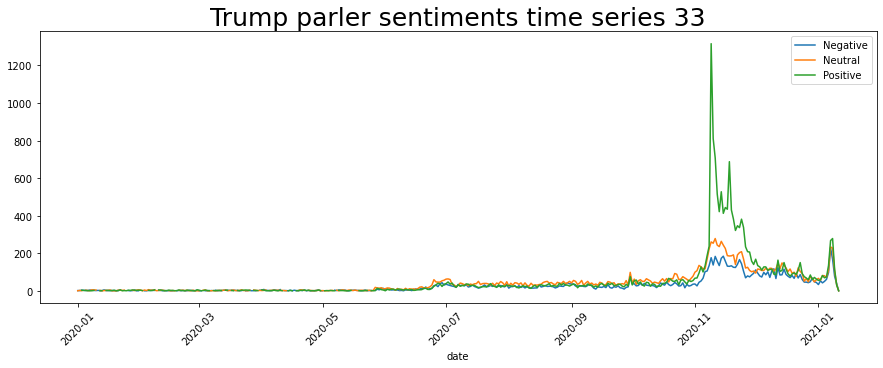

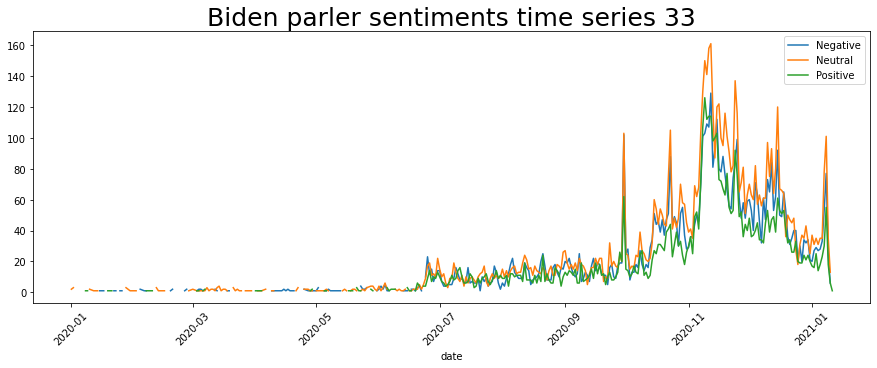

In [10]:
# Read each file of the dataset and preprocess it.
path = './Archive'
all_files = glob.glob(path + '/*.csv')

for i, filename in enumerate(all_files):
    current_df = pd.read_csv(filename, index_col=None, header=0)
    preprocess(current_df, i)
    del current_df

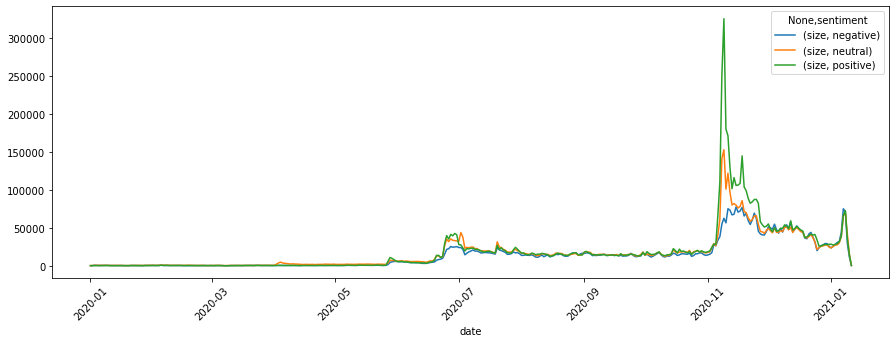

In [11]:
# Aggregate the sentiments from each dataset file, plot and store them in a json.
path = './data_pickles'
all_files = glob.glob(path + '/df_*.pickle')
    
li = []

for filename in all_files:
    current_df = pd.read_pickle(filename)
    li.append(current_df)
    del current_df

# Aggregate intermediate sentiment counts.
df = pd.concat(li, axis=0, ignore_index=True)
df.groupby('date').sum().reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=True)

to_store = df.groupby('date').sum().reset_index()
to_store.columns = to_store.columns.droplevel(level=0)
to_store.columns = ['date', 'negative', 'neutral', 'positive']

to_store['date'] = pd.to_datetime(to_store['date'])
to_store['date'] = to_store['date'].dt.strftime('%Y-%m-%d')

pos = to_store[['date', 'positive']].copy()
neg = to_store[['date', 'negative']].copy()

pos = pos.rename(columns={'positive': 'value'}).to_json('all_sentiment_positive.json', orient='records', date_format='iso')
neg = neg.rename(columns={'negative': 'value'}).to_json('all_sentiment_negative.json', orient='records', date_format='iso')

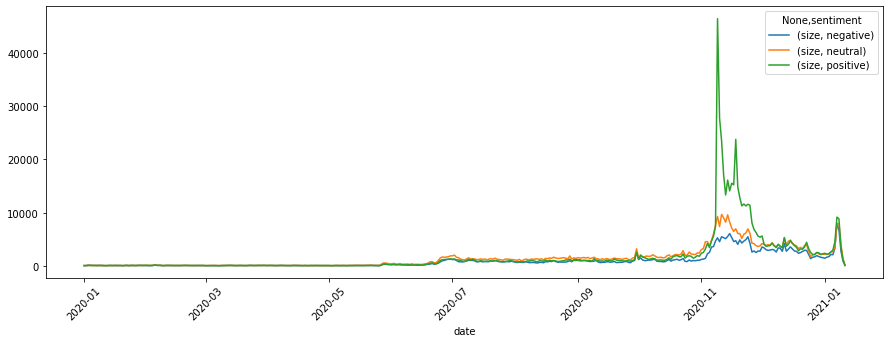

In [13]:
# Aggregate the sentiments from each dataset file for sentences containing
# the term `trump`, plot and store them in a json.
path = './data_pickles' # use your path
all_files = glob.glob(path + '/trump_df_*.pickle')
    
li = []

for filename in all_files:
    current_df = pd.read_pickle(filename)
    li.append(current_df)
    del current_df

# Aggregate intermediate sentiment counts.
trump_df = pd.concat(li, axis=0, ignore_index=True)
trump_df.groupby('date').sum().reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=True)

to_store = trump_df.groupby('date').sum().reset_index()
to_store.columns = to_store.columns.droplevel(level=0)
to_store.columns = ['date', 'negative', 'neutral', 'positive']

to_store['date'] = pd.to_datetime(to_store['date'])
to_store['date'] = to_store['date'].dt.strftime('%Y-%m-%d')

pos = to_store[['date', 'positive']].copy()
neg = to_store[['date', 'negative']].copy()

pos = pos.rename(columns={'positive': 'value'}).to_json('trump_sentiment_positive.json', orient='records', date_format='iso')
neg = neg.rename(columns={'negative': 'value'}).to_json('trump_sentiment_negative.json', orient='records', date_format='iso')

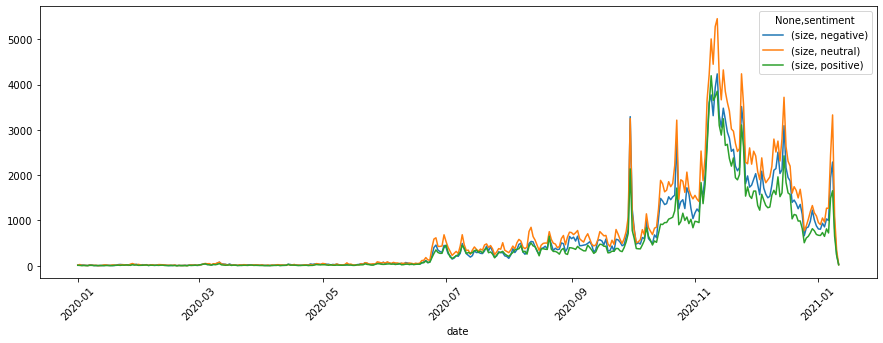

In [14]:
# Aggregate the sentiments from each dataset file for sentences containing
# the term `biden`, plot and store them in a json.
path = './data_pickles' # use your path
all_files = glob.glob(path + '/biden_df_*.pickle')
    
li = []

for filename in all_files:
    current_df = pd.read_pickle(filename)
    li.append(current_df)
    del current_df

# Aggregate intermediate sentiment counts.
biden_df = pd.concat(li, axis=0, ignore_index=True)
biden_df.groupby('date').sum().reset_index().sort_values(by='date', ascending=True).plot(figsize=(15,5), x='date', rot=45, legend=True)

to_store = biden_df.groupby('date').sum().reset_index()
to_store.columns = to_store.columns.droplevel(level=0)
to_store.columns = ['date', 'negative', 'neutral', 'positive']

to_store['date'] = pd.to_datetime(to_store['date'])
to_store['date'] = to_store['date'].dt.strftime('%Y-%m-%d')

pos = to_store[['date', 'positive']].copy()
neg = to_store[['date', 'negative']].copy()

pos = pos.rename(columns={'positive': 'value'}).to_json('biden_sentiment_positive.json', orient='records', date_format='iso')
neg = neg.rename(columns={'negative': 'value'}).to_json('biden_sentiment_negative.json', orient='records', date_format='iso')